**بسم الله الرحمن الرحیم**

**=====================================**

**------------Developing MFCCGAN-VC------------**

**=====================================**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

Mounted at /content/drive
Google Drive mounted successfully!


In [ ]:
import torch.multiprocessing as mp
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
import torchaudio.transforms as T
from tqdm.notebook import tqdm
import numpy as np
import time

In [ ]:
import os
import torch # Assuming torch is imported earlier as well for Config.DEVICE


# --- Configuration Class ---
# (Keep your existing Config class as is)
class Config:
    # Dataset paths
    VC_DIR = "/content/drive/MyDrive/Dataset/VCTK-Corpus-MRH-Experimental" # Base VCTK dataset directory
    VC_Output = "/content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2" # Base VCTK dataset directory
    WAV_DIR = os.path.join(VC_DIR, "wav48") # Directory containing wav files
    METADATA_PATH = os.path.join(VC_DIR, "speaker-info.txt") # Speaker metadata file path

    # Audio processing parameters
    SAMPLE_RATE = 16000 # Target sample rate for all audio (Hz)
    N_MELS = 80         # Number of Mel bands for spectrogram
    N_FFT = 400         # FFT window size (samples)
    HOP_LENGTH = 160    # Hop length (samples) between windows

    # Training parameters
    BATCH_SIZE = 32
    NUM_WORKERS = 2    # Number of CPU workers for data loading
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    NUM_EPOCHS = 50
    TRAIN_SPLIT_RATIO = 0.8 # 80% for training, 20% for validation
    RANDOM_SEED = 42    # For reproducibility

    # Device configuration
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Model parameters (Specific to this VC architecture)
    Z_CONTENT_DIM = 256 # Dimension for speaker-invariant content embedding
    Z_GENDER_DIM = 16   # Dimension for gender embedding
    Z_ACCENT_DIM = 64   # Dimension for accent embedding
    Z_SPEAKER_ID_DIM = 256 # Dimension for individual speaker ID embedding (like x-vector)
    Z_AGE_DIM = 32      # Dimension for age embedding (you can adjust this)
    Z_REGION_DIM = 64   # Dimension for region embedding (you can adjust this)

# Create directories if they don't exist
if not os.path.exists(Config.VC_DIR):
    os.makedirs(Config.VC_DIR)
if not os.path.exists(Config.WAV_DIR):
    os.makedirs(Config.WAV_DIR)

print(f"Using device: {Config.DEVICE}")
print(f"VC_DIR: {Config.VC_DIR}")
print(f"WAV_DIR: {Config.WAV_DIR}")


# --- Step 1: Load and Process Speaker Metadata ---
# This part reads your speaker-info.txt to get AGE, GENDER, ACCENTS, and REGION for each speaker ID.
speaker_metadata = {}
unique_genders = set()
unique_accents = set()
unique_regions = set() # New set for unique regions
unique_ages = set()
all_speaker_ids = set()

# Load metadata from speaker-info.txt
try:
    with open(Config.METADATA_PATH, 'r') as f:
        # Skip header
        header = f.readline().strip().split() # This reads "ID AGE GENDER ACCENTS REGION"
        print(f"Metadata header found: {header}")

        for line in f:
            parts = line.strip().split()
            # The 'REGION' column can have multiple words (e.g., "Southern England").
            # Simple split might combine "Southern" and "England" if there are multiple spaces,
            # but usually, for VCTK, it's tab-separated or fixed-width, or just space-separated
            # where multi-word regions are still handled as single entries after the accent.

            # Let's adjust based on the structure:
            # ID (0), AGE (1), GENDER (2), ACCENTS (3), REGION (4 onwards)
            if len(parts) >= 5: # Ensure there are enough parts for ID, AGE, GENDER, ACCENTS, REGION
                speaker_id = parts[0]
                age = parts[1] # Age is typically an integer, but can be read as string first
                gender = parts[2]
                accent = parts[3]
                # Region might be multiple words, so join the rest of the parts
                region = " ".join(parts[4:])

                # Store all extracted information
                speaker_metadata[speaker_id] = {
                    'age': age,
                    'gender': gender,
                    'accent': accent,
                    'region': region
                }
                unique_genders.add(gender)
                unique_accents.add(accent)
                unique_regions.add(region) # Add region to the set
                unique_ages.add(age)
                all_speaker_ids.add(speaker_id)
            else:
                print(f"Warning: Skipping malformed line in metadata: {line.strip()} (expected at least 5 parts)")

except FileNotFoundError:
    print(f"Error: speaker-info.txt not found at {Config.METADATA_PATH}.")
    print("Please ensure the VCTK dataset is correctly set up and the path is accurate.")
    # Exit or handle gracefully if essential file is missing
    exit()
except Exception as e:
    print(f"An unexpected error occurred while reading metadata: {e}")
    exit()

# Create integer mappings for categorical data (gender, accent, region)
speaker_id_to_int = {sid: i for i, sid in enumerate(sorted(list(all_speaker_ids)))}
gender_to_id = {gender: i for i, gender in enumerate(sorted(list(unique_genders)))}
accent_to_id = {accent: i for i, accent in enumerate(sorted(list(unique_accents)))}
region_to_id = {region: i for i, region in enumerate(sorted(list(unique_regions)))} # New mapping for regions
age_to_id = {age: i for i, age in enumerate(sorted(list(unique_ages)))} # New mapping for ages

print(f"Loaded metadata for {len(speaker_metadata)} speakers.")
print(f"Unique Genders: {unique_genders} (Mapped to: {gender_to_id})")
print(f"Unique Accents: {unique_accents} (Mapped to: {accent_to_id})")
print(f"Unique Regions: {unique_regions} (Mapped to: {region_to_id})") # Print regions
print(f"Unique ages: {unique_ages} (Mapped to: {age_to_id})") # Print ages
print(f"Total Speakers: {len(speaker_id_to_int)}")

# Example of accessing the new data for a speaker (e.g., '225')
if '225' in speaker_metadata:
    print(f"\nExample speaker '225' metadata: {speaker_metadata['225']}")
    print(f"Mapped IDs for speaker '225':")
    print(f"  Speaker ID: {speaker_id_to_int['225']}")
    print(f"  Gender ID: {gender_to_id[speaker_metadata['225']['gender']]}")
    print(f"  Accent ID: {accent_to_id[speaker_metadata['225']['accent']]}")
    print(f"  Region ID: {region_to_id[speaker_metadata['225']['region']]}")
    print(f"  Age ID: {age_to_id[speaker_metadata['225']['age']]}")

Using device: cuda
VC_DIR: /content/drive/MyDrive/Dataset/VCTK-Corpus-MRH-Experimental
WAV_DIR: /content/drive/MyDrive/Dataset/VCTK-Corpus-MRH-Experimental/wav48
Metadata header found: ['ID', 'AGE', 'GENDER', 'ACCENTS', 'REGION']
Loaded metadata for 102 speakers.
Unique Genders: {'M', 'F'} (Mapped to: {'F': 0, 'M': 1})
Unique Accents: {'NorthernIrish', 'SouthAfrican', 'Australian', 'NewZealand', 'American', 'Welsh', 'Canadian', 'Scottish', 'Irish', 'English'} (Mapped to: {'American': 0, 'Australian': 1, 'Canadian': 2, 'English': 3, 'Irish': 4, 'NewZealand': 5, 'NorthernIrish': 6, 'Scottish': 7, 'SouthAfrican': 8, 'Welsh': 9})
Unique Regions: {'Belfast', 'Suffolk', 'Philadelphia', 'Hamilton', 'Southern England', 'SW England', 'Cork', 'North Carolina', 'California', 'Derry', 'Chicago', 'Dublin', 'Surrey', 'Midlothian', 'Donegal', 'Oxford', 'Stockton-on-tees', 'Pretoria', 'Florida', 'San Francisco', 'York', 'English Sydney', 'County Down', 'London', 'West Lothian', 'Johannesburg', 'Manche

In [ ]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset # Added Subset import
from tqdm import tqdm

# Assuming Config is defined and the metadata processing (Step 1)
# which defines speaker_metadata, speaker_id_to_int, gender_to_id,
# accent_to_id, region_to_id, and age_to_id has been executed.

# --- Step 2: VCTK Dataset Preparation (Mel Spectrograms) ---
# Define the Mel Spectrogram transform (CPU-bound initially)
mel_spectrogram_transform_cpu = T.MelSpectrogram( # Renamed for clarity
    sample_rate=Config.SAMPLE_RATE,
    n_fft=Config.N_FFT,
    hop_length=Config.HOP_LENGTH,
    n_mels=Config.N_MELS
)

# worker_transforms = {} # This is not needed as it's handled within the dataset object

class VCTKMelDataset(Dataset):
    def __init__(self, wav_dir, speaker_metadata, speaker_id_to_int,
                 gender_to_id, accent_to_id, region_to_id, age_to_id, # Added region_to_id, age_to_id
                 mel_transform_cpu):
        self.wav_dir = wav_dir
        self.speaker_metadata = speaker_metadata
        self.speaker_id_to_int = speaker_id_to_int
        self.gender_to_id = gender_to_id
        self.accent_to_id = accent_to_id
        self.region_to_id = region_to_id # Store new mappings
        self.age_to_id = age_to_id       # Store new mappings

        self.mel_transform_cpu = mel_transform_cpu

        # These will be initialized per worker in worker_init_fn
        # (or manually for num_workers=0)
        self.mel_transform_on_device = None
        self.resampler_cache = {}

        self.data_samples = self._load_data_samples()

    def _load_data_samples(self):
        data_samples = []
        print("Loading audio file paths and preparing dataset indices...")
        for speaker_id_from_metadata in tqdm(self.speaker_id_to_int.keys(), desc="Processing Speakers"):
            speaker_dir_name = speaker_id_from_metadata
            if not speaker_dir_name.startswith('p'):
                speaker_dir_name = 'p' + speaker_dir_name
            speaker_path = os.path.join(self.wav_dir, speaker_dir_name)

            if not os.path.isdir(speaker_path):
                print(f"Warning: Speaker directory {speaker_path} not found. Skipping.")
                continue

            # Retrieve all metadata for the current speaker
            speaker_info = self.speaker_metadata[speaker_id_from_metadata]

            speaker_int_id = self.speaker_id_to_int[speaker_id_from_metadata]

            gender_label = speaker_info['gender']
            gender_int_id = self.gender_to_id[gender_label]

            accent_label = speaker_info['accent']
            accent_int_id = self.accent_to_id[accent_label]

            # NEW: Get region and age labels and their integer IDs
            region_label = speaker_info['region']
            region_int_id = self.region_to_id[region_label]

            age_label = speaker_info['age']
            age_int_id = self.age_to_id[age_label]


            for filename in os.listdir(speaker_path):
                if filename.endswith(".wav"):
                    file_path = os.path.join(speaker_path, filename)
                    data_samples.append({
                        'file_path': file_path,
                        'speaker_id': speaker_int_id,
                        'gender_id': gender_int_id,
                        'accent_id': accent_int_id,
                        'region_id': region_int_id, # Added
                        'age_id': age_int_id         # Added
                    })
        print(f"Finished loading {len(data_samples)} audio file paths.")
        return data_samples

    def __len__(self):
        return len(self.data_samples)

    def __getitem__(self, idx):
        # Ensure transforms are initialized. This block serves as a fallback for num_workers=0,
        # but for num_workers > 0, worker_init_fn will handle it.
        if self.mel_transform_on_device is None:
            # print(f"WARNING: Transforms not initialized by worker_init_fn. Doing it now in __getitem__ for main process.")
            self.mel_transform_on_device = self.mel_transform_cpu.to(Config.DEVICE)
            self.resampler_cache = {}

        sample_info = self.data_samples[idx]
        file_path = sample_info['file_path']

        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"ERROR loading {file_path}: {e}")
            raise # Re-raise to get full traceback

        resampler_on_device = None
        if sample_rate != Config.SAMPLE_RATE:
            resampler_key = f"{sample_rate}_to_{Config.SAMPLE_RATE}"
            if resampler_key not in self.resampler_cache:
                self.resampler_cache[resampler_key] = T.Resample(orig_freq=sample_rate, new_freq=Config.SAMPLE_RATE).to(Config.DEVICE)
            resampler_on_device = self.resampler_cache[resampler_key]

        if resampler_on_device is not None:
            waveform = resampler_on_device(waveform.to(Config.DEVICE))
        else:
            waveform = waveform.to(Config.DEVICE)

        if waveform.shape[0] > 1:
            waveform = waveform[0, :].unsqueeze(0)

        mel_spec = self.mel_transform_on_device(waveform)
        mel_spec = torch.log(mel_spec + 1e-6)
        mel_spec = mel_spec.squeeze(0)

        return {
            'mel_spec': mel_spec.cpu(),
            'speaker_id': torch.tensor(sample_info['speaker_id'], dtype=torch.long),
            'gender_id': torch.tensor(sample_info['gender_id'], dtype=torch.long),
            'accent_id': torch.tensor(sample_info['accent_id'], dtype=torch.long),
            'region_id': torch.tensor(sample_info['region_id'], dtype=torch.long), # Added
            'age_id': torch.tensor(sample_info['age_id'], dtype=torch.long)         # Added
        }

def collate_fn(batch):
    max_time = max(item['mel_spec'].shape[1] for item in batch)
    padded_mel_specs = []
    for item in batch:
        mel_spec = item['mel_spec']
        padding_size = max_time - mel_spec.shape[1]
        padded_mel = F.pad(mel_spec, (0, padding_size), "constant", 0)
        padded_mel_specs.append(padded_mel)
    batch_mel_specs = torch.stack(padded_mel_specs)

    batch_speaker_ids = torch.stack([item['speaker_id'] for item in batch])
    batch_gender_ids = torch.stack([item['gender_id'] for item in batch])
    batch_accent_ids = torch.stack([item['accent_id'] for item in batch])
    batch_region_ids = torch.stack([item['region_id'] for item in batch]) # Added
    batch_age_ids = torch.stack([item['age_id'] for item in batch])       # Added

    return {
        'mel_spec': batch_mel_specs,
        'speaker_id': batch_speaker_ids,
        'gender_id': batch_gender_ids,
        'accent_id': batch_accent_ids,
        'region_id': batch_region_ids, # Added
        'age_id': batch_age_ids         # Added
    }

def worker_init_fn(worker_id):
    # print(f"Worker {worker_id}: worker_init_fn started.") # Uncomment for debugging
    worker_info = torch.utils.data.get_worker_info()
    if worker_info is not None:
        dataset_obj = worker_info.dataset
        if isinstance(dataset_obj, Subset):
            actual_dataset = dataset_obj.dataset
        else:
            actual_dataset = dataset_obj

        # Move the mel transform to the correct device for this worker
        actual_dataset.mel_transform_on_device = actual_dataset.mel_transform_cpu.to(Config.DEVICE)
        # Initialize an empty cache for resamplers for this worker
        actual_dataset.resampler_cache = {}
        # print(f"Worker {worker_id}: worker_init_fn finished.") # Uncomment for debugging

# --- Main execution of Step 2 ---
# IMPORTANT: If num_workers=0, the worker_init_fn is NOT called.
# In that case, you need to manually move the mel_transform to the device for the main process.
if Config.NUM_WORKERS == 0:
    print("Running with num_workers=0. Manually moving Mel transform to device for main process.")
    mel_spectrogram_transform_cpu = mel_spectrogram_transform_cpu.to(Config.DEVICE) # Move to device for main process

vctk_dataset = VCTKMelDataset(
    wav_dir=Config.WAV_DIR,
    speaker_metadata=speaker_metadata,
    speaker_id_to_int=speaker_id_to_int,
    gender_to_id=gender_to_id,
    accent_to_id=accent_to_id,
    region_to_id=region_to_id, # Pass new mapping
    age_to_id=age_to_id,       # Pass new mapping
    mel_transform_cpu=mel_spectrogram_transform_cpu # Use the explicitly named CPU transform
)

vctk_dataloader = DataLoader(
    vctk_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=0, # Set back to Config.NUM_WORKERS for proper usage
    collate_fn=collate_fn,
    pin_memory=True if Config.DEVICE == 'cuda' else False, # Pin memory for GPU
    worker_init_fn=worker_init_fn if Config.NUM_WORKERS > 0 else None # Only pass worker_init_fn if workers > 0
)

print(f"\nDataset created with {len(vctk_dataset)} samples.")
print(f"DataLoader created with {len(vctk_dataloader)} batches (batch size: {Config.BATCH_SIZE}).")

print("\nTesting DataLoader...")
try:
    for i, batch in enumerate(vctk_dataloader):
        print(f"Batch {i+1}:")
        print(f"  Mel Spectrograms shape: {batch['mel_spec'].shape} on {batch['mel_spec'].device}")
        print(f"  Speaker IDs shape: {batch['speaker_id'].shape} on {batch['speaker_id'].device}")
        print(f"  Gender IDs shape: {batch['gender_id'].shape} on {batch['gender_id'].device}")
        print(f"  Accent IDs shape: {batch['accent_id'].shape} on {batch['accent_id'].device}")
        print(f"  Region IDs shape: {batch['region_id'].shape} on {batch['region_id'].device}") # Added
        print(f"  Age IDs shape: {batch['age_id'].shape} on {batch['age_id'].device}")           # Added
        if i == 0:
            print(f"  Example Speaker IDs: {batch['speaker_id'][:5].tolist()}")
            print(f"  Example Gender IDs: {batch['gender_id'][:5].tolist()}")
            print(f"  Example Accent IDs: {batch['accent_id'][:5].tolist()}")
            print(f"  Example Region IDs: {batch['region_id'][:5].tolist()}") # Added
            print(f"  Example Age IDs: {batch['age_id'][:5].tolist()}")       # Added
        break # Process only one batch for testing
    print("DataLoader test successful!")
except Exception as e:
    print(f"DataLoader test failed: {e}")
    import traceback
    traceback.print_exc() # Print full traceback

Loading audio file paths and preparing dataset indices...


Processing Speakers: 100%|██████████| 102/102 [00:00<00:00, 1368.06it/s]

Finished loading 1970 audio file paths.

Dataset created with 1970 samples.
DataLoader created with 62 batches (batch size: 32).

Testing DataLoader...


Batch 1:
  Mel Spectrograms shape: torch.Size([32, 80, 945]) on cpu
  Speaker IDs shape: torch.Size([32]) on cpu
  Gender IDs shape: torch.Size([32]) on cpu
  Accent IDs shape: torch.Size([32]) on cpu
  Region IDs shape: torch.Size([32]) on cpu
  Age IDs shape: torch.Size([32]) on cpu
  Example Speaker IDs: [37, 70, 18, 59, 86]
  Example Gender IDs: [0, 1, 1, 1, 0]
  Example Accent IDs: [4, 6, 4, 6, 0]
  Example Region IDs: [4, 5, 17, 5, 26]
  Example Age IDs: [4, 4, 7, 5, 1]
DataLoader test successful!


In [ ]:
# --- Step 3: Define Hierarchical Speaker Encoders & Content Encoder ---

class ConvBlock(nn.Module):
    """A simple Convolutional Block with optional Batch Normalization and LeakyReLU."""
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding,
                 use_bn=True, use_dropout=False):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm1d(out_channels) if use_bn else None
        self.relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.2) if use_dropout else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        x = self.relu(x)
        if self.dropout:
            x = self.dropout(x)
        return x

class SharedAudioFeatureExtractor(nn.Module):
    """Initial shared layers to extract general features from Mel spectrograms."""
    def __init__(self, n_mels, hidden_dims=[128, 256, 256]):
        super().__init__()
        layers = []
        in_c = n_mels
        for h_dim in hidden_dims:
            layers.append(ConvBlock(in_c, h_dim, kernel_size=5, stride=2, padding=2))
            in_c = h_dim
        self.conv_blocks = nn.Sequential(*layers)
        self.out_channels = hidden_dims[-1]

    def forward(self, mel_spec):
        # mel_spec shape: (Batch, N_MELS, N_FRAMES)
        x = self.conv_blocks(mel_spec) # (Batch, out_channels, Reduced_Frames)
        return x

class GenderEncoder(nn.Module):
    """Encodes gender specific features."""
    def __init__(self, in_channels, num_genders, z_gender_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, in_channels // 2, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool1d(1), # Global average pooling
            nn.Flatten(),
            nn.Linear(in_channels // 2, z_gender_dim) # Output gender embedding
        )
        self.classifier = nn.Linear(z_gender_dim, num_genders) # For classification objective

    def forward(self, x):
        z_gender = self.encoder(x)
        gender_logits = self.classifier(z_gender)
        return z_gender, gender_logits

class AccentEncoder(nn.Module):
    """Encodes accent specific features."""
    def __init__(self, in_channels, num_accents, z_accent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, in_channels // 2, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool1d(1), # Global average pooling
            nn.Flatten(),
            nn.Linear(in_channels // 2, z_accent_dim) # Output accent embedding
        )
        self.classifier = nn.Linear(z_accent_dim, num_accents) # For classification objective

    def forward(self, x):
        z_accent = self.encoder(x)
        accent_logits = self.classifier(z_accent)
        return z_accent, accent_logits

# NEW: Age Encoder
class AgeEncoder(nn.Module):
    """Encodes age specific features."""
    def __init__(self, in_channels, num_ages, z_age_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, in_channels // 2, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool1d(1), # Global average pooling
            nn.Flatten(),
            nn.Linear(in_channels // 2, z_age_dim) # Output age embedding
        )
        self.classifier = nn.Linear(z_age_dim, num_ages) # For classification objective

    def forward(self, x):
        z_age = self.encoder(x)
        age_logits = self.classifier(z_age)
        return z_age, age_logits

# NEW: Region Encoder
class RegionEncoder(nn.Module):
    """Encodes region specific features."""
    def __init__(self, in_channels, num_regions, z_region_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, in_channels // 2, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool1d(1), # Global average pooling
            nn.Flatten(),
            nn.Linear(in_channels // 2, z_region_dim) # Output region embedding
        )
        self.classifier = nn.Linear(z_region_dim, num_regions) # For classification objective

    def forward(self, x):
        z_region = self.encoder(x)
        region_logits = self.classifier(z_region)
        return z_region, region_logits

class SpeakerIDEncoder(nn.Module):
    """Encodes individual speaker ID features (similar to x-vectors)."""
    def __init__(self, in_channels, num_speakers, z_speaker_id_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, in_channels * 2, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels * 2, in_channels * 2, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool1d(1), # Global average pooling
            nn.Flatten(),
            nn.Linear(in_channels * 2, z_speaker_id_dim) # Output speaker ID embedding
        )
        self.classifier = nn.Linear(z_speaker_id_dim, num_speakers) # For classification/verification objective

    def forward(self, x):
        z_speaker_id = self.encoder(x)
        speaker_logits = self.classifier(z_speaker_id)
        return z_speaker_id, speaker_logits

class ContentEncoder(nn.Module):
    """Encodes speaker-invariant linguistic content features."""
    def __init__(self, n_mels, z_content_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(n_mels, 128, kernel_size=5, stride=1, padding=2),
            ConvBlock(128, 128, kernel_size=5, stride=1, padding=2),
            ConvBlock(128, z_content_dim, kernel_size=5, stride=1, padding=2, use_bn=False), # No BN on last layer often
        )
        # Output is (Batch, Z_CONTENT_DIM, N_FRAMES) - a sequence of content embeddings

    def forward(self, mel_spec):
        z_content = self.encoder(mel_spec)
        return z_content

class VoiceConversionEncoders(nn.Module):
    """Combines all encoders for the VC task."""
    def __init__(self, config, num_genders, num_accents, num_speakers, num_ages, num_regions): # Added num_ages, num_regions
        super().__init__()
        self.shared_extractor = SharedAudioFeatureExtractor(config.N_MELS)
        shared_out_channels = self.shared_extractor.out_channels

        self.gender_encoder = GenderEncoder(shared_out_channels, num_genders, config.Z_GENDER_DIM)
        self.accent_encoder = AccentEncoder(shared_out_channels, num_accents, config.Z_ACCENT_DIM)
        self.speaker_id_encoder = SpeakerIDEncoder(shared_out_channels, num_speakers, config.Z_SPEAKER_ID_DIM)

        # NEW: Instantiate AgeEncoder and RegionEncoder
        self.age_encoder = AgeEncoder(shared_out_channels, num_ages, config.Z_AGE_DIM)
        self.region_encoder = RegionEncoder(shared_out_channels, num_regions, config.Z_REGION_DIM)


        self.content_encoder = ContentEncoder(config.N_MELS, config.Z_CONTENT_DIM)

    def forward(self, mel_spec):
        # Shared feature extraction
        shared_features = self.shared_extractor(mel_spec) # (Batch, C, T')

        # Pooled features for speaker attributes
        pooled_shared_features = F.adaptive_avg_pool1d(shared_features, 1).squeeze(-1) # (Batch, C)

        # Gender
        z_gender, gender_logits = self.gender_encoder(pooled_shared_features.unsqueeze(-1))

        # Accent
        z_accent, accent_logits = self.accent_encoder(pooled_shared_features.unsqueeze(-1))

        # Speaker ID
        z_speaker_id, speaker_id_logits = self.speaker_id_encoder(pooled_shared_features.unsqueeze(-1))

        # NEW: Age
        z_age, age_logits = self.age_encoder(pooled_shared_features.unsqueeze(-1))

        # NEW: Region
        z_region, region_logits = self.region_encoder(pooled_shared_features.unsqueeze(-1))

        # Content Encoder (operates on raw Mel, aims to be speaker-independent)
        z_content = self.content_encoder(mel_spec) # (Batch, Z_CONTENT_DIM, N_FRAMES)

        return {
            'z_content': z_content,
            'z_gender': z_gender,
            'gender_logits': gender_logits,
            'z_accent': z_accent,
            'accent_logits': accent_logits,
            'z_speaker_id': z_speaker_id,
            'speaker_id_logits': speaker_id_logits,
            'z_age': z_age,          # Added
            'age_logits': age_logits, # Added
            'z_region': z_region,    # Added
            'region_logits': region_logits, # Added
        }

# Example usage (assuming num_genders, num_accents, num_speakers, num_ages, num_regions are defined)
# This part would typically be in your training script, after metadata loading
if __name__ == '__main__':
    # Dummy data for testing
    num_genders = len(gender_to_id) # Replace with actual count from metadata
    num_accents = len(accent_to_id)
    num_speakers = len(speaker_id_to_int)
    num_ages = len(age_to_id)
    num_regions = len(region_to_id)

    # Assume a batch of Mel spectrograms
    batch_size = Config.BATCH_SIZE
    n_mels = Config.N_MELS
    max_frames = 200 # Example max frames
    dummy_mel_spec = torch.randn(batch_size, n_mels, max_frames).to(Config.DEVICE)

    # Initialize the combined encoders
    encoders = VoiceConversionEncoders(Config, num_genders, num_accents, num_speakers, num_ages, num_regions).to(Config.DEVICE)

    # Forward pass
    output = encoders(dummy_mel_spec)

    print("\nEncoder Outputs:")
    for key, value in output.items():
        if isinstance(value, torch.Tensor):
            print(f"  {key}: shape={value.shape}, device={value.device}")
        else:
            print(f"  {key}: {type(value)}")

    print("\n--- Model Architecture ---")
    # print(encoders)


Encoder Outputs:
  z_content: shape=torch.Size([32, 256, 200]), device=cuda:0
  z_gender: shape=torch.Size([32, 16]), device=cuda:0
  gender_logits: shape=torch.Size([32, 2]), device=cuda:0
  z_accent: shape=torch.Size([32, 64]), device=cuda:0
  accent_logits: shape=torch.Size([32, 10]), device=cuda:0
  z_speaker_id: shape=torch.Size([32, 256]), device=cuda:0
  speaker_id_logits: shape=torch.Size([32, 102]), device=cuda:0
  z_age: shape=torch.Size([32, 32]), device=cuda:0
  age_logits: shape=torch.Size([32, 15]), device=cuda:0
  z_region: shape=torch.Size([32, 64]), device=cuda:0
  region_logits: shape=torch.Size([32, 67]), device=cuda:0

--- Model Architecture ---


In [ ]:
# --- Initialize Encoders ---
# Use the lengths from your metadata processing (Step 1)
num_genders = len(gender_to_id)
num_accents = len(accent_to_id)
num_speakers = len(speaker_id_to_int)
num_ages = len(age_to_id)     # NEW: Get count of unique ages
num_regions = len(region_to_id) # NEW: Get count of unique regions

vc_encoders = VoiceConversionEncoders(
    Config,
    num_genders,
    num_accents,
    num_speakers,
    num_ages,    # NEW: Pass num_ages
    num_regions  # NEW: Pass num_regions
).to(Config.DEVICE)

print(f"\nVoice Conversion Encoders initialized and moved to {Config.DEVICE}.")
# print(vc_encoders)

# --- Test forward pass ---
print("\n--- Testing Encoder Forward Pass ---")
with torch.no_grad():
    try:
        test_batch = next(iter(vctk_dataloader))
        # Ensure batch is moved to the correct device
        test_mel_spec = test_batch['mel_spec'].to(Config.DEVICE)

        encoder_outputs = vc_encoders(test_mel_spec) # Pass only mel_spec

        print(f"z_content shape: {encoder_outputs['z_content'].shape}")
        print(f"z_gender shape: {encoder_outputs['z_gender'].shape}")
        print(f"gender_logits shape: {encoder_outputs['gender_logits'].shape}")
        print(f"z_accent shape: {encoder_outputs['z_accent'].shape}")
        print(f"accent_logits shape: {encoder_outputs['accent_logits'].shape}")
        print(f"z_speaker_id shape: {encoder_outputs['z_speaker_id'].shape}")
        print(f"speaker_id_logits shape: {encoder_outputs['speaker_id_logits'].shape}")
        # NEW: Print shapes for age and region outputs
        print(f"z_age shape: {encoder_outputs['z_age'].shape}")
        print(f"age_logits shape: {encoder_outputs['age_logits'].shape}")
        print(f"z_region shape: {encoder_outputs['z_region'].shape}")
        print(f"region_logits shape: {encoder_outputs['region_logits'].shape}")


        # Check if z_content's time dimension matches input Mel's time dimension
        input_frames = test_mel_spec.shape[2]
        content_frames = encoder_outputs['z_content'].shape[2]
        print(f"Input Mel frames: {input_frames}, Content Latent frames: {content_frames}")

    except StopIteration:
        print("DataLoader is empty, skipping encoder test.")
    except Exception as e:
        print(f"An error occurred during encoder forward pass test: {e}")
        import traceback
        traceback.print_exc()

print("Encoder forward pass test complete.")


Voice Conversion Encoders initialized and moved to cuda.

--- Testing Encoder Forward Pass ---
z_content shape: torch.Size([32, 256, 927])
z_gender shape: torch.Size([32, 16])
gender_logits shape: torch.Size([32, 2])
z_accent shape: torch.Size([32, 64])
accent_logits shape: torch.Size([32, 10])
z_speaker_id shape: torch.Size([32, 256])
speaker_id_logits shape: torch.Size([32, 102])
z_age shape: torch.Size([32, 32])
age_logits shape: torch.Size([32, 15])
z_region shape: torch.Size([32, 64])
region_logits shape: torch.Size([32, 67])
Input Mel frames: 927, Content Latent frames: 927
Encoder forward pass test complete.


In [ ]:
# --- Step 4: Define Loss Functions and Optimizers ---

# Loss Functions
# Using CrossEntropyLoss for classification tasks
gender_criterion = nn.CrossEntropyLoss()
accent_criterion = nn.CrossEntropyLoss()
speaker_id_criterion = nn.CrossEntropyLoss()

# NEW: Add CrossEntropyLoss for age and region classification
age_criterion = nn.CrossEntropyLoss()
region_criterion = nn.CrossEntropyLoss()

# Optimizer
# We will optimize all parameters of the vc_encoders
optimizer = torch.optim.AdamW(vc_encoders.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)

print("\nLoss functions and Optimizer defined.")
# CORRECTED LINE HERE:
print(f"Optimizer: {optimizer.__class__.__name__} with learning rate {Config.LEARNING_RATE} and weight decay {Config.WEIGHT_DECAY}")

# --- Optional: Print number of trainable parameters ---
total_params = sum(p.numel() for p in vc_encoders.parameters() if p.requires_grad)
print(f"Total trainable parameters in vc_encoders: {total_params:,}")


Loss functions and Optimizer defined.
Optimizer: AdamW with learning rate 0.0001 and weight decay 1e-05
Total trainable parameters in vc_encoders: 3,592,756


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from tqdm import tqdm
import numpy as np # For random splitting

# Assume Config, speaker_metadata, speaker_id_to_int, gender_to_id,
# accent_to_id, region_to_id, age_to_id are already defined from Step 1.

# Assume mel_spectrogram_transform_cpu is defined and VCTKMelDataset,
# collate_fn, worker_init_fn are defined from Step 2.

# Assume vc_encoders, gender_criterion, accent_criterion, speaker_id_criterion,
# age_criterion, region_criterion, optimizer are defined from Step 3 & 4.

# --- Data Splitting Logic ---
print("\n--- Performing Dataset Splits (Train, In-Test, Out-Test) ---")

# First, create the full dataset
vctk_dataset = VCTKMelDataset(
    wav_dir=Config.WAV_DIR,
    speaker_metadata=speaker_metadata,
    speaker_id_to_int=speaker_id_to_int,
    gender_to_id=gender_to_id,
    accent_to_id=accent_to_id,
    region_to_id=region_to_id,
    age_to_id=age_to_id,
    mel_transform_cpu=mel_spectrogram_transform_cpu # This should be the CPU-bound transform
)

# Get all unique speaker IDs that have data in the dataset
# It's important to iterate through the data_samples to get speakers *actually present*
all_speakers_in_dataset = list(set(s['speaker_id'] for s in vctk_dataset.data_samples))
np.random.seed(Config.RANDOM_SEED) # Ensure reproducibility for splits
np.random.shuffle(all_speakers_in_dataset)

# Determine out-test speakers (e.g., 10% of total speakers)
num_out_test_speakers = int(len(all_speakers_in_dataset) * 0.10)
out_test_speaker_ids = set(all_speakers_in_dataset[:num_out_test_speakers])
in_train_val_test_speaker_ids = set(all_speakers_in_dataset[num_out_test_speakers:])

print(f"Total speakers with data: {len(all_speakers_in_dataset)}")
print(f"Out-test speakers ({num_out_test_speakers}): {[k for k,v in speaker_id_to_int.items() if v in out_test_speaker_ids]}") # Map back to original IDs for readability

# --- Create Indices for each split ---
train_indices = []
in_test_indices = [] # Seen speakers, unseen utterances
out_test_indices = [] # Unseen speakers, unseen utterances

# Dictionaries to hold indices for each speaker for "in-test" split
speaker_utterance_indices = {speaker_id: [] for speaker_id in in_train_val_test_speaker_ids}

# Populate indices
for i, sample in enumerate(vctk_dataset.data_samples):
    speaker_id = sample['speaker_id']
    if speaker_id in out_test_speaker_ids:
        out_test_indices.append(i)
    elif speaker_id in in_train_val_test_speaker_ids:
        speaker_utterance_indices[speaker_id].append(i)
    # No 'else' needed as all_speakers_in_dataset covers all
    # speakers that actually have data.

# Now, split the in_train_val_test speakers' utterances into train and in-test
for speaker_id, indices in speaker_utterance_indices.items():
    np.random.shuffle(indices) # Shuffle utterances for each speaker
    # For in-test, take a percentage of utterances from each speaker (e.g., 10%)
    num_in_test_utterances = int(len(indices) * 0.10)
    in_test_indices.extend(indices[:num_in_test_utterances])
    train_indices.extend(indices[num_in_test_utterances:])

# Further split 'train_indices' into actual train and validation sets
# (e.g., 80% train, 20% validation from the train_indices)
np.random.shuffle(train_indices) # Shuffle before splitting
num_train_samples = int(len(train_indices) * Config.TRAIN_SPLIT_RATIO)
actual_train_indices = train_indices[:num_train_samples]
val_indices = train_indices[num_train_samples:]

print(f"Total samples: {len(vctk_dataset)}")
print(f"Train samples: {len(actual_train_indices)}")
print(f"Validation samples: {len(val_indices)}")
print(f"In-Test samples (seen speakers, unseen utterances): {len(in_test_indices)}")
print(f"Out-Test samples (unseen speakers, unseen utterances): {len(out_test_indices)}")


# Create Subset objects for each split
train_dataset = Subset(vctk_dataset, actual_train_indices)
val_dataset = Subset(vctk_dataset, val_indices)
in_test_dataset = Subset(vctk_dataset, in_test_indices)
out_test_dataset = Subset(vctk_dataset, out_test_indices)

# --- Create DataLoaders for each split ---
train_dataloader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=True if Config.DEVICE == 'cuda' else False,
    worker_init_fn=worker_init_fn if Config.NUM_WORKERS > 0 else None
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=True if Config.DEVICE == 'cuda' else False,
    worker_init_fn=worker_init_fn if Config.NUM_WORKERS > 0 else None
)

in_test_dataloader = DataLoader(
    in_test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False, # No need to shuffle test data
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=True if Config.DEVICE == 'cuda' else False,
    worker_init_fn=worker_init_fn if Config.NUM_WORKERS > 0 else None
)

out_test_dataloader = DataLoader(
    out_test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False, # No need to shuffle test data
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=True if Config.DEVICE == 'cuda' else False,
    worker_init_fn=worker_init_fn if Config.NUM_WORKERS > 0 else None
)

print(f"\nDataLoaders created for Train ({len(train_dataloader)} batches), Validation ({len(val_dataloader)} batches),")
print(f"In-Test ({len(in_test_dataloader)} batches), and Out-Test ({len(out_test_dataloader)} batches).")


--- Performing Dataset Splits (Train, In-Test, Out-Test) ---
Loading audio file paths and preparing dataset indices...


Processing Speakers: 100%|██████████| 102/102 [00:00<00:00, 1096.91it/s]

Finished loading 1970 audio file paths.
Total speakers with data: 101
Out-test speakers (10): ['225', '236', '250', '268', '273', '274', '285', '300', '301', '326']
Total samples: 1970
Train samples: 1296
Validation samples: 324
In-Test samples (seen speakers, unseen utterances): 154
Out-Test samples (unseen speakers, unseen utterances): 196

DataLoaders created for Train (41 batches), Validation (11 batches),
In-Test (5 batches), and Out-Test (7 batches).


In [ ]:
class Config:
    # Dataset paths
    VC_DIR = "/content/drive/MyDrive/Dataset/VCTK-Corpus-MRH-Experimental" # Base VCTK dataset directory
    VC_Output = "/content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2" # Base VCTK dataset directory
    WAV_DIR = os.path.join(VC_DIR, "wav48") # Directory containing wav files
    METADATA_PATH = os.path.join(VC_DIR, "speaker-info.txt") # Speaker metadata file path

    # Audio processing parameters
    SAMPLE_RATE = 16000 # Target sample rate for all audio (Hz)
    N_MELS = 80         # Number of Mel bands for spectrogram
    N_FFT = 400         # FFT window size (samples)
    HOP_LENGTH = 160    # Hop length (samples) between windows

    # Training parameters
    BATCH_SIZE = 32
    NUM_WORKERS = 2    # Number of CPU workers for data loading
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    NUM_EPOCHS = 50
    TRAIN_SPLIT_RATIO = 0.8 # 80% for training, 20% for validation
    RANDOM_SEED = 42    # For reproducibility

    # Device configuration
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Model parameters (Specific to this VC architecture)
    Z_CONTENT_DIM = 256 # Dimension for speaker-invariant content embedding
    Z_GENDER_DIM = 16   # Dimension for gender embedding
    Z_ACCENT_DIM = 64   # Dimension for accent embedding
    Z_SPEAKER_ID_DIM = 256 # Dimension for individual speaker ID embedding (like x-vector)
    Z_AGE_DIM = 32      # Dimension for age embedding (you can adjust this)
    Z_REGION_DIM = 64   # Dimension for region embedding (you can adjust this)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from tqdm import tqdm
import numpy as np # For random splitting

# Assume Config, speaker_metadata, speaker_id_to_int, gender_to_id,
# accent_to_id, region_to_id, age_to_id are already defined from Step 1.

# Assume mel_spectrogram_transform_cpu is defined and VCTKMelDataset,
# collate_fn, worker_init_fn are defined from Step 2.

# Assume vc_encoders (which now includes age and region encoders),
# and all _criterion objects (gender_criterion, accent_criterion,
# speaker_id_criterion, age_criterion, region_criterion) are defined from Step 3 & 4.
# Also assume optimizer is defined.

# --- Training and Validation Functions (Updated) ---

def train_epoch(model, dataloader, optimizer,
                gender_criterion, accent_criterion, speaker_id_criterion,
                age_criterion, region_criterion, # Added age and region criteria
                device):
    model.train() # Set the model to training mode
    total_loss = 0.0
    gender_loss_sum = 0.0
    accent_loss_sum = 0.0
    speaker_id_loss_sum = 0.0
    age_loss_sum = 0.0     # Added
    region_loss_sum = 0.0  # Added

    # Track correct predictions for accuracy
    correct_gender = 0
    total_gender = 0
    correct_accent = 0
    total_accent = 0
    correct_speaker_id = 0
    total_speaker_id = 0
    correct_age = 0      # Added
    total_age = 0        # Added
    correct_region = 0   # Added
    total_region = 0     # Added


    pbar = tqdm(dataloader, desc="Training", leave=False)
    for batch_idx, batch in enumerate(pbar):
        mel_spec = batch['mel_spec'].to(device)
        speaker_id_labels = batch['speaker_id'].to(device)
        gender_id_labels = batch['gender_id'].to(device)
        accent_id_labels = batch['accent_id'].to(device)
        age_id_labels = batch['age_id'].to(device)       # Added
        region_id_labels = batch['region_id'].to(device) # Added


        optimizer.zero_grad() # Clear gradients

        # Forward pass
        encoder_outputs = model(mel_spec)

        # Calculate individual losses
        gender_loss = gender_criterion(encoder_outputs['gender_logits'], gender_id_labels)
        accent_loss = accent_criterion(encoder_outputs['accent_logits'], accent_id_labels)
        speaker_id_loss = speaker_id_criterion(encoder_outputs['speaker_id_logits'], speaker_id_labels)
        age_loss = age_criterion(encoder_outputs['age_logits'], age_id_labels)         # Added
        region_loss = region_criterion(encoder_outputs['region_logits'], region_id_labels) # Added


        # Combine losses (you might want to use different weights for these later)
        # For now, a simple sum.
        total_batch_loss = gender_loss + accent_loss + speaker_id_loss + age_loss + region_loss # Added age/region


        # Backward pass and optimize
        total_batch_loss.backward()
        optimizer.step()

        # Accumulate losses
        total_loss += total_batch_loss.item()
        gender_loss_sum += gender_loss.item()
        accent_loss_sum += accent_loss.item()
        speaker_id_loss_sum += speaker_id_loss.item()
        age_loss_sum += age_loss.item()         # Added
        region_loss_sum += region_loss.item()   # Added


        # Calculate accuracies
        _, predicted_gender = torch.max(encoder_outputs['gender_logits'], 1)
        correct_gender += (predicted_gender == gender_id_labels).sum().item()
        total_gender += gender_id_labels.size(0)

        _, predicted_accent = torch.max(encoder_outputs['accent_logits'], 1)
        correct_accent += (predicted_accent == accent_id_labels).sum().item()
        total_accent += accent_id_labels.size(0)

        _, predicted_speaker_id = torch.max(encoder_outputs['speaker_id_logits'], 1)
        correct_speaker_id += (predicted_speaker_id == speaker_id_labels).sum().item()
        total_speaker_id += speaker_id_labels.size(0)

        _, predicted_age = torch.max(encoder_outputs['age_logits'], 1)          # Added
        correct_age += (predicted_age == age_id_labels).sum().item()            # Added
        total_age += age_id_labels.size(0)                                      # Added

        _, predicted_region = torch.max(encoder_outputs['region_logits'], 1)    # Added
        correct_region += (predicted_region == region_id_labels).sum().item()   # Added
        total_region += region_id_labels.size(0)                                # Added


        pbar.set_postfix({
            'T_Loss': f'{total_batch_loss.item():.4f}',
            'G_Acc': f'{100 * correct_gender / total_gender:.2f}%',
            'A_Acc': f'{100 * correct_accent / total_accent:.2f}%',
            'S_Acc': f'{100 * correct_speaker_id / total_speaker_id:.2f}%',
            'Age_Acc': f'{100 * correct_age / total_age:.2f}%',        # Added
            'Region_Acc': f'{100 * correct_region / total_region:.2f}%' # Added
        })


    avg_loss = total_loss / len(dataloader)
    avg_gender_loss = gender_loss_sum / len(dataloader)
    avg_accent_loss = accent_loss_sum / len(dataloader)
    avg_speaker_id_loss = speaker_id_loss_sum / len(dataloader)
    avg_age_loss = age_loss_sum / len(dataloader)         # Added
    avg_region_loss = region_loss_sum / len(dataloader)    # Added


    gender_accuracy = correct_gender / total_gender if total_gender > 0 else 0
    accent_accuracy = correct_accent / total_accent if total_accent > 0 else 0
    speaker_id_accuracy = correct_speaker_id / total_speaker_id if total_speaker_id > 0 else 0
    age_accuracy = correct_age / total_age if total_age > 0 else 0         # Added
    region_accuracy = correct_region / total_region if total_region > 0 else 0 # Added


    return (avg_loss, avg_gender_loss, avg_accent_loss, avg_speaker_id_loss, avg_age_loss, avg_region_loss, # Added age/region to return
            gender_accuracy, accent_accuracy, speaker_id_accuracy, age_accuracy, region_accuracy) # Added age/region to return


def validate_epoch(model, dataloader,
                   gender_criterion, accent_criterion, speaker_id_criterion,
                   age_criterion, region_criterion, # Added age and region criteria
                   device):
    model.eval() # Set the model to evaluation mode
    total_loss = 0.0
    gender_loss_sum = 0.0
    accent_loss_sum = 0.0
    speaker_id_loss_sum = 0.0
    age_loss_sum = 0.0      # Added
    region_loss_sum = 0.0   # Added

    correct_gender = 0
    total_gender = 0
    correct_accent = 0
    total_accent = 0
    correct_speaker_id = 0
    total_speaker_id = 0
    correct_age = 0       # Added
    total_age = 0         # Added
    correct_region = 0    # Added
    total_region = 0      # Added


    with torch.no_grad(): # Disable gradient calculation for validation
        pbar = tqdm(dataloader, desc="Validation", leave=False)
        for batch_idx, batch in enumerate(pbar):
            mel_spec = batch['mel_spec'].to(device)
            speaker_id_labels = batch['speaker_id'].to(device)
            gender_id_labels = batch['gender_id'].to(device)
            accent_id_labels = batch['accent_id'].to(device)
            age_id_labels = batch['age_id'].to(device)         # Added
            region_id_labels = batch['region_id'].to(device)   # Added


            # Forward pass
            encoder_outputs = model(mel_spec)

            # Calculate individual losses
            gender_loss = gender_criterion(encoder_outputs['gender_logits'], gender_id_labels)
            accent_loss = accent_criterion(encoder_outputs['accent_logits'], accent_id_labels)
            speaker_id_loss = speaker_id_criterion(encoder_outputs['speaker_id_logits'], speaker_id_labels)
            age_loss = age_criterion(encoder_outputs['age_logits'], age_id_labels)         # Added
            region_loss = region_criterion(encoder_outputs['region_logits'], region_id_labels) # Added


            # Combine losses
            total_batch_loss = gender_loss + accent_loss + speaker_id_loss + age_loss + region_loss # Added age/region


            # Accumulate losses
            total_loss += total_batch_loss.item()
            gender_loss_sum += gender_loss.item()
            accent_loss_sum += accent_loss.item()
            speaker_id_loss_sum += speaker_id_loss.item()
            age_loss_sum += age_loss.item()         # Added
            region_loss_sum += region_loss.item()   # Added


            # Calculate accuracies
            _, predicted_gender = torch.max(encoder_outputs['gender_logits'], 1)
            correct_gender += (predicted_gender == gender_id_labels).sum().item()
            total_gender += gender_id_labels.size(0)

            _, predicted_accent = torch.max(encoder_outputs['accent_logits'], 1)
            correct_accent += (predicted_accent == accent_id_labels).sum().item()
            total_accent += accent_id_labels.size(0)

            _, predicted_speaker_id = torch.max(encoder_outputs['speaker_id_logits'], 1)
            correct_speaker_id += (predicted_speaker_id == speaker_id_labels).sum().item()
            total_speaker_id += speaker_id_labels.size(0)

            _, predicted_age = torch.max(encoder_outputs['age_logits'], 1)          # Added
            correct_age += (predicted_age == age_id_labels).sum().item()            # Added
            total_age += age_id_labels.size(0)                                      # Added

            _, predicted_region = torch.max(encoder_outputs['region_logits'], 1)    # Added
            correct_region += (predicted_region == region_id_labels).sum().item()   # Added
            total_region += region_id_labels.size(0)                                # Added


            pbar.set_postfix({
                'V_Loss': f'{total_batch_loss.item():.4f}',
                'G_Acc': f'{100 * correct_gender / total_gender:.2f}%',
                'A_Acc': f'{100 * correct_accent / total_accent:.2f}%',
                'S_Acc': f'{100 * correct_speaker_id / total_speaker_id:.2f}%',
                'Age_Acc': f'{100 * correct_age / total_age:.2f}%',        # Added
                'Region_Acc': f'{100 * correct_region / total_region:.2f}%' # Added
            })


    avg_loss = total_loss / len(dataloader)
    avg_gender_loss = gender_loss_sum / len(dataloader)
    avg_accent_loss = accent_loss_sum / len(dataloader)
    avg_speaker_id_loss = speaker_id_loss_sum / len(dataloader)
    avg_age_loss = age_loss_sum / len(dataloader)          # Added
    avg_region_loss = region_loss_sum / len(dataloader)     # Added


    gender_accuracy = correct_gender / total_gender if total_gender > 0 else 0
    accent_accuracy = correct_accent / total_accent if total_accent > 0 else 0
    speaker_id_accuracy = correct_speaker_id / total_speaker_id if total_speaker_id > 0 else 0
    age_accuracy = correct_age / total_age if total_age > 0 else 0          # Added
    region_accuracy = correct_region / total_region if total_region > 0 else 0 # Added


    return (avg_loss, avg_gender_loss, avg_accent_loss, avg_speaker_id_loss, avg_age_loss, avg_region_loss, # Added age/region to return
            gender_accuracy, accent_accuracy, speaker_id_accuracy, age_accuracy, region_accuracy) # Added age/region to return


# --- Main Training Loop (with metric storage) ---
print("\nStarting training...")
best_val_loss = float('inf')

# Initialize lists to store metrics
train_losses = []
train_gender_losses = []
train_accent_losses = []
train_speaker_id_losses = []
train_age_losses = []
train_region_losses = []
train_gender_accs = []
train_accent_accs = []
train_speaker_id_accs = []
train_age_accs = []
train_region_accs = []

val_losses = []
val_gender_losses = []
val_accent_losses = []
val_speaker_id_losses = []
val_age_losses = []
val_region_losses = []
val_gender_accs = []
val_accent_accs = []
val_speaker_id_accs = []
val_age_accs = []
val_region_accs = []


for epoch in range(Config.NUM_EPOCHS):
    (train_loss, train_gender_loss, train_accent_loss, train_speaker_id_loss,
     train_age_loss, train_region_loss,
     train_gender_acc, train_accent_acc, train_speaker_id_acc,
     train_age_acc, train_region_acc) = train_epoch(
        vc_encoders, train_dataloader, optimizer,
        gender_criterion, accent_criterion, speaker_id_criterion,
        age_criterion, region_criterion,
        Config.DEVICE
    )

    (val_loss, val_gender_loss, val_accent_loss, val_speaker_id_loss,
     val_age_loss, val_region_loss,
     val_gender_acc, val_accent_acc, val_speaker_id_acc,
     val_age_acc, val_region_acc) = validate_epoch(
        vc_encoders, val_dataloader,
        gender_criterion, accent_criterion, speaker_id_criterion,
        age_criterion, region_criterion,
        Config.DEVICE
    )

    # Store metrics
    train_losses.append(train_loss)
    train_gender_losses.append(train_gender_loss)
    train_accent_losses.append(train_accent_loss)
    train_speaker_id_losses.append(train_speaker_id_loss)
    train_age_losses.append(train_age_loss)
    train_region_losses.append(train_region_loss)
    train_gender_accs.append(train_gender_acc)
    train_accent_accs.append(train_accent_acc)
    train_speaker_id_accs.append(train_speaker_id_acc)
    train_age_accs.append(train_age_acc)
    train_region_accs.append(train_region_acc)

    val_losses.append(val_loss)
    val_gender_losses.append(val_gender_loss)
    val_accent_losses.append(val_accent_loss)
    val_speaker_id_losses.append(val_speaker_id_loss)
    val_age_losses.append(val_age_loss)
    val_region_losses.append(val_region_loss)
    val_gender_accs.append(val_gender_acc)
    val_accent_accs.append(val_accent_acc)
    val_speaker_id_accs.append(val_speaker_id_acc)
    val_age_accs.append(val_age_acc)
    val_region_accs.append(val_region_acc)


    print(f"\nEpoch {epoch+1}/{Config.NUM_EPOCHS}:")
    print(f"  Train -> Total Loss: {train_loss:.4f} | "
          f"G_L: {train_gender_loss:.4f} (A: {train_gender_acc*100:.2f}%) | "
          f"A_L: {train_accent_loss:.4f} (A: {train_accent_acc*100:.2f}%) | "
          f"S_L: {train_speaker_id_loss:.4f} (A: {train_speaker_id_acc*100:.2f}%) | "
          f"Age_L: {train_age_loss:.4f} (A: {train_age_acc*100:.2f}%) | "
          f"Region_L: {train_region_loss:.4f} (A: {train_region_acc*100:.2f}%)"
         )
    print(f"  Valid -> Total Loss: {val_loss:.4f} | "
          f"G_L: {val_gender_loss:.4f} (A: {val_gender_acc*100:.2f}%) | "
          f"A_L: {val_accent_loss:.4f} (A: {val_accent_acc*100:.2f}%) | "
          f"S_L: {val_speaker_id_loss:.4f} (A: {val_speaker_id_acc*100:.2f}%) | "
          f"Age_L: {val_age_loss:.4f} (A: {val_age_acc*100:.2f}%) | "
          f"Region_L: {val_region_loss:.4f} (A: {val_region_acc*100:.2f}%)"
         )

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_save_path = os.path.join(Config.VC_Output, "best_vc_encoders.pth")
        torch.save(vc_encoders.state_dict(), model_save_path)
        print(f"  Model saved to {model_save_path} (Validation Loss: {best_val_loss:.4f})\n")
    else:
        print(f"  Validation loss did not improve from {best_val_loss:.4f}\n")

print("\n--- Training complete! ---")


# --- Evaluate on Test Sets ---
print("\n--- Evaluating on Test Sets ---")

# Load the best model for final evaluation
model_load_path = os.path.join(Config.VC_Output, "best_vc_encoders.pth")
if os.path.exists(model_load_path):
    vc_encoders.load_state_dict(torch.load(model_load_path, map_location=Config.DEVICE))
    print(f"Loaded best model from {model_load_path} for final evaluation.")
else:
    print(f"Warning: Best model not found at {model_load_path}. Evaluating with current model state.")

# In-Test Evaluation
(in_test_loss, in_test_gender_loss, in_test_accent_loss, in_test_speaker_id_loss,
 in_test_age_loss, in_test_region_loss, # Added
 in_test_gender_acc, in_test_accent_acc, in_test_speaker_id_acc,
 in_test_age_acc, in_test_region_acc) = validate_epoch( # Added (using validate_epoch in inference mode)
    vc_encoders, in_test_dataloader,
    gender_criterion, accent_criterion, speaker_id_criterion,
    age_criterion, region_criterion, # Added
    Config.DEVICE
)
print(f"\nIn-Test Set -> Total Loss: {in_test_loss:.4f} | "
      f"G_L: {in_test_gender_loss:.4f} (A: {in_test_gender_acc*100:.2f}%) | "
      f"A_L: {in_test_accent_loss:.4f} (A: {in_test_accent_acc*100:.2f}%) | "
      f"S_L: {in_test_speaker_id_loss:.4f} (A: {in_test_speaker_id_acc*100:.2f}%) | "
      f"Age_L: {in_test_age_loss:.4f} (A: {in_test_age_acc*100:.2f}%) | "       # Added
      f"Region_L: {in_test_region_loss:.4f} (A: {in_test_region_acc*100:.2f}%)" # Added
     )

# Out-Test Evaluation
(out_test_loss, out_test_gender_loss, out_test_accent_loss, out_test_speaker_id_loss,
 out_test_age_loss, out_test_region_loss, # Added
 out_test_gender_acc, out_test_accent_acc, out_test_speaker_id_acc,
 out_test_age_acc, out_test_region_acc) = validate_epoch( # Added (using validate_epoch in inference mode)
    vc_encoders, out_test_dataloader,
    gender_criterion, accent_criterion, speaker_id_criterion,
    age_criterion, region_criterion, # Added
    Config.DEVICE
)
print(f"\nOut-Test Set -> Total Loss: {out_test_loss:.4f} | "
      f"G_L: {out_test_gender_loss:.4f} (A: {out_test_gender_acc*100:.2f}%) | "
      f"A_L: {out_test_accent_loss:.4f} (A: {out_test_accent_acc*100:.2f}%) | "
      f"S_L: {out_test_speaker_id_loss:.4f} (A: {out_test_speaker_id_acc*100:.2f}%) | "
      f"Age_L: {out_test_age_loss:.4f} (A: {out_test_age_acc*100:.2f}%) | "       # Added
      f"Region_L: {out_test_region_loss:.4f} (A: {out_test_region_acc*100:.2f}%)" # Added
     )

print("\nFull training and test evaluation complete!")


Starting training...



Epoch 1/50:
  Train -> Total Loss: 13.0256 | G_L: 0.2775 (A: 94.68%) | A_L: 2.0187 (A: 34.95%) | S_L: 4.1834 (A: 16.51%) | Age_L: 2.5075 (A: 22.84%) | Region_L: 4.0385 (A: 10.42%)
  Valid -> Total Loss: 13.2985 | G_L: 0.3249 (A: 99.07%) | A_L: 2.0535 (A: 45.06%) | S_L: 4.3066 (A: 16.67%) | Age_L: 2.5458 (A: 23.15%) | Region_L: 4.0677 (A: 14.20%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 13.2985)




Epoch 2/50:
  Train -> Total Loss: 10.6856 | G_L: 0.1182 (A: 98.46%) | A_L: 1.5667 (A: 58.10%) | S_L: 3.2175 (A: 55.02%) | Age_L: 2.1332 (A: 48.30%) | Region_L: 3.6500 (A: 33.10%)
  Valid -> Total Loss: 10.8080 | G_L: 0.0968 (A: 99.07%) | A_L: 1.7786 (A: 50.31%) | S_L: 3.1398 (A: 36.11%) | Age_L: 2.1355 (A: 43.21%) | Region_L: 3.6574 (A: 20.99%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 10.8080)




Epoch 3/50:
  Train -> Total Loss: 8.9197 | G_L: 0.0750 (A: 99.23%) | A_L: 1.2674 (A: 65.43%) | S_L: 2.4320 (A: 74.85%) | Age_L: 1.8060 (A: 60.42%) | Region_L: 3.3393 (A: 47.53%)
  Valid -> Total Loss: 9.6006 | G_L: 0.1404 (A: 95.99%) | A_L: 1.4637 (A: 59.57%) | S_L: 2.5466 (A: 55.25%) | Age_L: 2.0571 (A: 34.26%) | Region_L: 3.3928 (A: 26.85%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 9.6006)




Epoch 4/50:
  Train -> Total Loss: 7.4304 | G_L: 0.0577 (A: 99.23%) | A_L: 1.0181 (A: 72.15%) | S_L: 1.7888 (A: 87.27%) | Age_L: 1.5126 (A: 69.29%) | Region_L: 3.0532 (A: 57.79%)
  Valid -> Total Loss: 8.4868 | G_L: 0.0872 (A: 99.38%) | A_L: 1.3236 (A: 54.32%) | S_L: 2.0498 (A: 71.30%) | Age_L: 1.8375 (A: 45.99%) | Region_L: 3.1887 (A: 39.51%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 8.4868)




Epoch 5/50:
  Train -> Total Loss: 6.1977 | G_L: 0.0421 (A: 99.61%) | A_L: 0.8349 (A: 79.55%) | S_L: 1.2704 (A: 91.90%) | Age_L: 1.2540 (A: 74.61%) | Region_L: 2.7963 (A: 63.89%)
  Valid -> Total Loss: 7.0124 | G_L: 0.0607 (A: 97.84%) | A_L: 0.9605 (A: 70.06%) | S_L: 1.4784 (A: 87.96%) | Age_L: 1.5963 (A: 49.07%) | Region_L: 2.9165 (A: 50.31%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 7.0124)




Epoch 6/50:
  Train -> Total Loss: 5.2061 | G_L: 0.0277 (A: 99.92%) | A_L: 0.6696 (A: 84.72%) | S_L: 0.8933 (A: 95.45%) | Age_L: 1.0736 (A: 79.32%) | Region_L: 2.5420 (A: 68.75%)
  Valid -> Total Loss: 7.8401 | G_L: 0.0281 (A: 99.38%) | A_L: 1.9757 (A: 36.42%) | S_L: 1.3804 (A: 81.17%) | Age_L: 1.6796 (A: 47.22%) | Region_L: 2.7763 (A: 56.48%)
  Validation loss did not improve from 7.0124




Epoch 7/50:
  Train -> Total Loss: 4.4291 | G_L: 0.0253 (A: 99.69%) | A_L: 0.5456 (A: 89.12%) | S_L: 0.6418 (A: 97.15%) | Age_L: 0.9104 (A: 83.02%) | Region_L: 2.3060 (A: 73.30%)
  Valid -> Total Loss: 5.3826 | G_L: 0.0546 (A: 99.38%) | A_L: 0.8689 (A: 67.28%) | S_L: 0.8819 (A: 91.67%) | Age_L: 1.0910 (A: 67.28%) | Region_L: 2.4863 (A: 60.80%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 5.3826)




Epoch 8/50:
  Train -> Total Loss: 3.7935 | G_L: 0.0197 (A: 99.69%) | A_L: 0.4534 (A: 91.28%) | S_L: 0.4702 (A: 97.69%) | Age_L: 0.7725 (A: 86.50%) | Region_L: 2.0777 (A: 77.70%)
  Valid -> Total Loss: 5.4010 | G_L: 0.0554 (A: 99.07%) | A_L: 0.9074 (A: 70.06%) | S_L: 0.8272 (A: 91.67%) | Age_L: 1.1780 (A: 62.35%) | Region_L: 2.4330 (A: 55.56%)
  Validation loss did not improve from 5.3826




Epoch 9/50:
  Train -> Total Loss: 3.2960 | G_L: 0.0214 (A: 99.77%) | A_L: 0.3790 (A: 93.44%) | S_L: 0.3612 (A: 98.38%) | Age_L: 0.6678 (A: 89.66%) | Region_L: 1.8666 (A: 81.10%)
  Valid -> Total Loss: 8.2124 | G_L: 0.0197 (A: 99.69%) | A_L: 2.4990 (A: 35.80%) | S_L: 1.1055 (A: 76.23%) | Age_L: 1.4963 (A: 52.16%) | Region_L: 3.0918 (A: 20.37%)
  Validation loss did not improve from 5.3826




Epoch 10/50:
  Train -> Total Loss: 2.8340 | G_L: 0.0142 (A: 99.92%) | A_L: 0.2922 (A: 96.45%) | S_L: 0.2794 (A: 98.53%) | Age_L: 0.5811 (A: 91.74%) | Region_L: 1.6672 (A: 85.34%)
  Valid -> Total Loss: 4.8104 | G_L: 0.0149 (A: 100.00%) | A_L: 0.5220 (A: 81.48%) | S_L: 0.6264 (A: 91.67%) | Age_L: 1.6194 (A: 41.05%) | Region_L: 2.0278 (A: 66.36%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 4.8104)




Epoch 11/50:
  Train -> Total Loss: 2.5053 | G_L: 0.0100 (A: 99.92%) | A_L: 0.2508 (A: 96.22%) | S_L: 0.2217 (A: 99.31%) | Age_L: 0.5189 (A: 92.75%) | Region_L: 1.5039 (A: 84.80%)
  Valid -> Total Loss: 3.9671 | G_L: 0.0239 (A: 99.69%) | A_L: 0.8005 (A: 70.06%) | S_L: 0.4469 (A: 94.44%) | Age_L: 0.7446 (A: 80.25%) | Region_L: 1.9512 (A: 57.41%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 3.9671)




Epoch 12/50:
  Train -> Total Loss: 2.1237 | G_L: 0.0101 (A: 99.85%) | A_L: 0.1974 (A: 98.15%) | S_L: 0.1733 (A: 99.38%) | Age_L: 0.4288 (A: 95.60%) | Region_L: 1.3141 (A: 89.27%)
  Valid -> Total Loss: 3.9679 | G_L: 0.0107 (A: 100.00%) | A_L: 0.5048 (A: 82.10%) | S_L: 0.4553 (A: 94.44%) | Age_L: 1.2224 (A: 59.57%) | Region_L: 1.7748 (A: 67.59%)
  Validation loss did not improve from 3.9671




Epoch 13/50:
  Train -> Total Loss: 1.8973 | G_L: 0.0154 (A: 99.69%) | A_L: 0.1714 (A: 97.84%) | S_L: 0.1464 (A: 99.38%) | Age_L: 0.3794 (A: 95.60%) | Region_L: 1.1848 (A: 90.51%)
  Valid -> Total Loss: 4.4002 | G_L: 0.2272 (A: 92.90%) | A_L: 0.4647 (A: 86.42%) | S_L: 0.5005 (A: 91.05%) | Age_L: 1.5249 (A: 54.01%) | Region_L: 1.6830 (A: 65.74%)
  Validation loss did not improve from 3.9671




Epoch 14/50:
  Train -> Total Loss: 1.6342 | G_L: 0.0115 (A: 99.69%) | A_L: 0.1523 (A: 97.99%) | S_L: 0.1164 (A: 99.54%) | Age_L: 0.3113 (A: 96.91%) | Region_L: 1.0427 (A: 93.13%)
  Valid -> Total Loss: 4.2663 | G_L: 0.0137 (A: 99.69%) | A_L: 0.3797 (A: 90.43%) | S_L: 0.5350 (A: 90.43%) | Age_L: 1.6954 (A: 50.00%) | Region_L: 1.6424 (A: 72.22%)
  Validation loss did not improve from 3.9671




Epoch 15/50:
  Train -> Total Loss: 1.4414 | G_L: 0.0056 (A: 100.00%) | A_L: 0.1350 (A: 98.38%) | S_L: 0.0953 (A: 99.85%) | Age_L: 0.2809 (A: 97.38%) | Region_L: 0.9245 (A: 94.14%)
  Valid -> Total Loss: 2.8455 | G_L: 0.0081 (A: 100.00%) | A_L: 0.2790 (A: 94.14%) | S_L: 0.3095 (A: 95.37%) | Age_L: 0.8963 (A: 72.53%) | Region_L: 1.3524 (A: 78.09%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 2.8455)




Epoch 16/50:
  Train -> Total Loss: 1.3189 | G_L: 0.0190 (A: 99.23%) | A_L: 0.1231 (A: 98.38%) | S_L: 0.0858 (A: 99.85%) | Age_L: 0.2707 (A: 97.38%) | Region_L: 0.8203 (A: 95.68%)
  Valid -> Total Loss: 4.3848 | G_L: 0.0177 (A: 99.69%) | A_L: 0.9079 (A: 73.77%) | S_L: 0.3804 (A: 95.06%) | Age_L: 1.3092 (A: 66.67%) | Region_L: 1.7697 (A: 52.16%)
  Validation loss did not improve from 2.8455




Epoch 17/50:
  Train -> Total Loss: 1.1477 | G_L: 0.0089 (A: 99.92%) | A_L: 0.1023 (A: 99.00%) | S_L: 0.0735 (A: 99.92%) | Age_L: 0.2198 (A: 98.46%) | Region_L: 0.7433 (A: 95.14%)
  Valid -> Total Loss: 3.0043 | G_L: 0.0078 (A: 100.00%) | A_L: 0.5010 (A: 85.19%) | S_L: 0.5283 (A: 88.58%) | Age_L: 0.7457 (A: 77.78%) | Region_L: 1.2215 (A: 79.63%)
  Validation loss did not improve from 2.8455




Epoch 18/50:
  Train -> Total Loss: 0.9679 | G_L: 0.0091 (A: 99.69%) | A_L: 0.0774 (A: 99.15%) | S_L: 0.0629 (A: 99.92%) | Age_L: 0.1848 (A: 98.46%) | Region_L: 0.6337 (A: 97.38%)
  Valid -> Total Loss: 2.2838 | G_L: 0.0038 (A: 100.00%) | A_L: 0.3814 (A: 87.35%) | S_L: 0.2397 (A: 95.99%) | Age_L: 0.5373 (A: 87.35%) | Region_L: 1.1217 (A: 79.32%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 2.2838)




Epoch 19/50:
  Train -> Total Loss: 0.8435 | G_L: 0.0043 (A: 99.92%) | A_L: 0.0711 (A: 99.38%) | S_L: 0.0490 (A: 99.85%) | Age_L: 0.1671 (A: 98.92%) | Region_L: 0.5520 (A: 97.99%)
  Valid -> Total Loss: 3.0640 | G_L: 0.0052 (A: 100.00%) | A_L: 0.5330 (A: 80.86%) | S_L: 0.3719 (A: 93.83%) | Age_L: 1.0239 (A: 68.52%) | Region_L: 1.1300 (A: 79.94%)
  Validation loss did not improve from 2.2838




Epoch 20/50:
  Train -> Total Loss: 0.7545 | G_L: 0.0050 (A: 99.92%) | A_L: 0.0640 (A: 99.61%) | S_L: 0.0478 (A: 99.92%) | Age_L: 0.1476 (A: 99.00%) | Region_L: 0.4901 (A: 97.61%)
  Valid -> Total Loss: 2.0532 | G_L: 0.0070 (A: 99.69%) | A_L: 0.2919 (A: 92.59%) | S_L: 0.2814 (A: 94.75%) | Age_L: 0.4714 (A: 88.27%) | Region_L: 1.0016 (A: 82.41%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 2.0532)




Epoch 21/50:
  Train -> Total Loss: 0.6476 | G_L: 0.0065 (A: 99.85%) | A_L: 0.0548 (A: 99.61%) | S_L: 0.0382 (A: 99.92%) | Age_L: 0.1212 (A: 99.54%) | Region_L: 0.4269 (A: 98.69%)
  Valid -> Total Loss: 2.7668 | G_L: 0.0127 (A: 99.69%) | A_L: 0.5899 (A: 79.01%) | S_L: 0.2246 (A: 95.99%) | Age_L: 0.9765 (A: 69.75%) | Region_L: 0.9631 (A: 76.85%)
  Validation loss did not improve from 2.0532




Epoch 22/50:
  Train -> Total Loss: 0.6260 | G_L: 0.0131 (A: 99.54%) | A_L: 0.0539 (A: 99.38%) | S_L: 0.0400 (A: 99.92%) | Age_L: 0.1138 (A: 99.54%) | Region_L: 0.4052 (A: 98.38%)
  Valid -> Total Loss: 1.9412 | G_L: 0.0079 (A: 99.38%) | A_L: 0.3315 (A: 90.12%) | S_L: 0.1795 (A: 96.60%) | Age_L: 0.6006 (A: 80.25%) | Region_L: 0.8217 (A: 93.83%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 1.9412)




Epoch 23/50:
  Train -> Total Loss: 0.5627 | G_L: 0.0127 (A: 99.85%) | A_L: 0.0518 (A: 99.54%) | S_L: 0.0325 (A: 100.00%) | Age_L: 0.1173 (A: 99.00%) | Region_L: 0.3484 (A: 99.00%)
  Valid -> Total Loss: 1.9714 | G_L: 0.0100 (A: 99.69%) | A_L: 0.4639 (A: 85.49%) | S_L: 0.2703 (A: 95.99%) | Age_L: 0.5078 (A: 89.20%) | Region_L: 0.7194 (A: 87.65%)
  Validation loss did not improve from 1.9412




Epoch 24/50:
  Train -> Total Loss: 0.5063 | G_L: 0.0072 (A: 99.85%) | A_L: 0.0464 (A: 99.46%) | S_L: 0.0293 (A: 100.00%) | Age_L: 0.1055 (A: 99.15%) | Region_L: 0.3180 (A: 99.23%)
  Valid -> Total Loss: 3.1375 | G_L: 0.0059 (A: 100.00%) | A_L: 0.4504 (A: 85.49%) | S_L: 0.2997 (A: 95.37%) | Age_L: 1.6355 (A: 57.72%) | Region_L: 0.7460 (A: 88.27%)
  Validation loss did not improve from 1.9412




Epoch 25/50:
  Train -> Total Loss: 0.4884 | G_L: 0.0026 (A: 99.92%) | A_L: 0.0565 (A: 99.46%) | S_L: 0.0332 (A: 99.92%) | Age_L: 0.1126 (A: 99.07%) | Region_L: 0.2835 (A: 99.23%)
  Valid -> Total Loss: 2.6076 | G_L: 0.0075 (A: 99.69%) | A_L: 0.3438 (A: 88.89%) | S_L: 0.3903 (A: 91.67%) | Age_L: 1.1421 (A: 68.83%) | Region_L: 0.7239 (A: 86.42%)
  Validation loss did not improve from 1.9412




Epoch 26/50:
  Train -> Total Loss: 0.3768 | G_L: 0.0037 (A: 99.92%) | A_L: 0.0280 (A: 99.92%) | S_L: 0.0244 (A: 99.92%) | Age_L: 0.0759 (A: 99.77%) | Region_L: 0.2447 (A: 99.61%)
  Valid -> Total Loss: 1.3578 | G_L: 0.0062 (A: 99.69%) | A_L: 0.2588 (A: 91.67%) | S_L: 0.1787 (A: 95.99%) | Age_L: 0.3770 (A: 88.89%) | Region_L: 0.5370 (A: 92.59%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 1.3578)




Epoch 27/50:
  Train -> Total Loss: 0.3788 | G_L: 0.0115 (A: 99.54%) | A_L: 0.0404 (A: 99.54%) | S_L: 0.0227 (A: 100.00%) | Age_L: 0.0706 (A: 99.69%) | Region_L: 0.2335 (A: 99.15%)
  Valid -> Total Loss: 4.5040 | G_L: 0.0490 (A: 98.15%) | A_L: 1.0757 (A: 68.21%) | S_L: 0.5648 (A: 83.95%) | Age_L: 1.6065 (A: 56.79%) | Region_L: 1.2081 (A: 72.84%)
  Validation loss did not improve from 1.3578




Epoch 28/50:
  Train -> Total Loss: 0.3820 | G_L: 0.0073 (A: 99.77%) | A_L: 0.0528 (A: 99.15%) | S_L: 0.0290 (A: 99.77%) | Age_L: 0.0691 (A: 99.69%) | Region_L: 0.2238 (A: 99.15%)
  Valid -> Total Loss: 3.7290 | G_L: 0.0173 (A: 99.69%) | A_L: 1.4636 (A: 67.28%) | S_L: 0.3740 (A: 92.59%) | Age_L: 0.5625 (A: 84.26%) | Region_L: 1.3116 (A: 63.89%)
  Validation loss did not improve from 1.3578




Epoch 29/50:
  Train -> Total Loss: 0.3621 | G_L: 0.0028 (A: 99.92%) | A_L: 0.0643 (A: 98.69%) | S_L: 0.0230 (A: 99.92%) | Age_L: 0.0819 (A: 99.00%) | Region_L: 0.1901 (A: 99.85%)
  Valid -> Total Loss: 2.4790 | G_L: 0.0090 (A: 99.38%) | A_L: 0.2872 (A: 91.36%) | S_L: 0.3650 (A: 91.05%) | Age_L: 1.0684 (A: 69.14%) | Region_L: 0.7493 (A: 87.35%)
  Validation loss did not improve from 1.3578




Epoch 30/50:
  Train -> Total Loss: 0.4626 | G_L: 0.0019 (A: 100.00%) | A_L: 0.0701 (A: 98.69%) | S_L: 0.0256 (A: 99.92%) | Age_L: 0.1409 (A: 97.30%) | Region_L: 0.2241 (A: 99.15%)
  Valid -> Total Loss: 3.0831 | G_L: 0.0113 (A: 99.69%) | A_L: 0.5400 (A: 80.25%) | S_L: 0.2143 (A: 95.99%) | Age_L: 1.7067 (A: 55.25%) | Region_L: 0.6109 (A: 93.83%)
  Validation loss did not improve from 1.3578




Epoch 31/50:
  Train -> Total Loss: 0.3675 | G_L: 0.0016 (A: 100.00%) | A_L: 0.0594 (A: 98.92%) | S_L: 0.0243 (A: 99.92%) | Age_L: 0.0898 (A: 99.23%) | Region_L: 0.1923 (A: 99.77%)
  Valid -> Total Loss: 6.7036 | G_L: 0.0138 (A: 99.38%) | A_L: 2.1806 (A: 51.85%) | S_L: 0.9504 (A: 75.31%) | Age_L: 2.0606 (A: 45.68%) | Region_L: 1.4982 (A: 62.04%)
  Validation loss did not improve from 1.3578




Epoch 32/50:
  Train -> Total Loss: 0.2523 | G_L: 0.0091 (A: 99.77%) | A_L: 0.0265 (A: 99.69%) | S_L: 0.0147 (A: 100.00%) | Age_L: 0.0511 (A: 99.85%) | Region_L: 0.1508 (A: 99.92%)
  Valid -> Total Loss: 1.3394 | G_L: 0.0712 (A: 97.84%) | A_L: 0.2631 (A: 90.74%) | S_L: 0.1529 (A: 96.91%) | Age_L: 0.2688 (A: 92.90%) | Region_L: 0.5834 (A: 91.67%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 1.3394)




Epoch 33/50:
  Train -> Total Loss: 0.2544 | G_L: 0.0071 (A: 99.85%) | A_L: 0.0327 (A: 99.61%) | S_L: 0.0144 (A: 100.00%) | Age_L: 0.0562 (A: 99.77%) | Region_L: 0.1440 (A: 99.46%)
  Valid -> Total Loss: 1.4593 | G_L: 0.0126 (A: 99.69%) | A_L: 0.2386 (A: 92.28%) | S_L: 0.1513 (A: 97.22%) | Age_L: 0.6131 (A: 82.41%) | Region_L: 0.4436 (A: 92.90%)
  Validation loss did not improve from 1.3394




Epoch 34/50:
  Train -> Total Loss: 0.2204 | G_L: 0.0071 (A: 99.77%) | A_L: 0.0280 (A: 99.77%) | S_L: 0.0131 (A: 100.00%) | Age_L: 0.0505 (A: 99.61%) | Region_L: 0.1217 (A: 99.77%)
  Valid -> Total Loss: 1.8411 | G_L: 0.0039 (A: 100.00%) | A_L: 0.2696 (A: 90.12%) | S_L: 0.2455 (A: 95.06%) | Age_L: 0.7273 (A: 79.94%) | Region_L: 0.5948 (A: 90.43%)
  Validation loss did not improve from 1.3394




Epoch 35/50:
  Train -> Total Loss: 0.2202 | G_L: 0.0022 (A: 99.92%) | A_L: 0.0494 (A: 98.84%) | S_L: 0.0118 (A: 100.00%) | Age_L: 0.0372 (A: 99.85%) | Region_L: 0.1196 (A: 99.85%)
  Valid -> Total Loss: 3.0929 | G_L: 0.0050 (A: 100.00%) | A_L: 1.2469 (A: 65.74%) | S_L: 0.2837 (A: 93.83%) | Age_L: 0.5973 (A: 81.17%) | Region_L: 0.9599 (A: 73.15%)
  Validation loss did not improve from 1.3394




Epoch 36/50:
  Train -> Total Loss: 0.2059 | G_L: 0.0020 (A: 100.00%) | A_L: 0.0348 (A: 99.31%) | S_L: 0.0103 (A: 100.00%) | Age_L: 0.0525 (A: 99.38%) | Region_L: 0.1063 (A: 99.77%)
  Valid -> Total Loss: 1.8597 | G_L: 0.0049 (A: 99.69%) | A_L: 0.2452 (A: 91.67%) | S_L: 0.1663 (A: 97.53%) | Age_L: 1.0018 (A: 75.62%) | Region_L: 0.4415 (A: 91.98%)
  Validation loss did not improve from 1.3394




Epoch 37/50:
  Train -> Total Loss: 0.1635 | G_L: 0.0017 (A: 100.00%) | A_L: 0.0194 (A: 99.61%) | S_L: 0.0094 (A: 100.00%) | Age_L: 0.0416 (A: 99.69%) | Region_L: 0.0916 (A: 99.77%)
  Valid -> Total Loss: 1.8170 | G_L: 0.0198 (A: 99.07%) | A_L: 0.5042 (A: 80.56%) | S_L: 0.2401 (A: 93.83%) | Age_L: 0.4350 (A: 86.42%) | Region_L: 0.6179 (A: 83.95%)
  Validation loss did not improve from 1.3394




Epoch 38/50:
  Train -> Total Loss: 0.1442 | G_L: 0.0015 (A: 100.00%) | A_L: 0.0165 (A: 99.85%) | S_L: 0.0098 (A: 100.00%) | Age_L: 0.0312 (A: 99.92%) | Region_L: 0.0851 (A: 100.00%)
  Valid -> Total Loss: 1.1031 | G_L: 0.0057 (A: 99.69%) | A_L: 0.2461 (A: 92.28%) | S_L: 0.1176 (A: 98.15%) | Age_L: 0.2506 (A: 95.06%) | Region_L: 0.4830 (A: 90.43%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 1.1031)




Epoch 39/50:
  Train -> Total Loss: 0.1779 | G_L: 0.0096 (A: 99.69%) | A_L: 0.0134 (A: 99.92%) | S_L: 0.0131 (A: 100.00%) | Age_L: 0.0518 (A: 99.38%) | Region_L: 0.0900 (A: 99.85%)
  Valid -> Total Loss: 3.9422 | G_L: 0.0893 (A: 96.60%) | A_L: 1.3402 (A: 59.57%) | S_L: 0.3020 (A: 93.83%) | Age_L: 1.2744 (A: 63.89%) | Region_L: 0.9363 (A: 72.22%)
  Validation loss did not improve from 1.1031




Epoch 40/50:
  Train -> Total Loss: 0.1400 | G_L: 0.0028 (A: 99.92%) | A_L: 0.0114 (A: 100.00%) | S_L: 0.0093 (A: 100.00%) | Age_L: 0.0401 (A: 99.77%) | Region_L: 0.0764 (A: 100.00%)
  Valid -> Total Loss: 1.3003 | G_L: 0.0104 (A: 99.38%) | A_L: 0.2835 (A: 91.36%) | S_L: 0.1632 (A: 96.60%) | Age_L: 0.4524 (A: 87.35%) | Region_L: 0.3907 (A: 91.98%)
  Validation loss did not improve from 1.1031




Epoch 41/50:
  Train -> Total Loss: 0.0978 | G_L: 0.0008 (A: 100.00%) | A_L: 0.0080 (A: 100.00%) | S_L: 0.0074 (A: 100.00%) | Age_L: 0.0231 (A: 99.92%) | Region_L: 0.0585 (A: 100.00%)
  Valid -> Total Loss: 2.1583 | G_L: 0.0143 (A: 99.07%) | A_L: 0.3279 (A: 88.27%) | S_L: 0.1570 (A: 97.22%) | Age_L: 1.2812 (A: 62.35%) | Region_L: 0.3780 (A: 96.60%)
  Validation loss did not improve from 1.1031




Epoch 42/50:
  Train -> Total Loss: 0.0953 | G_L: 0.0028 (A: 99.92%) | A_L: 0.0083 (A: 100.00%) | S_L: 0.0069 (A: 100.00%) | Age_L: 0.0197 (A: 100.00%) | Region_L: 0.0576 (A: 100.00%)
  Valid -> Total Loss: 0.6279 | G_L: 0.0073 (A: 99.69%) | A_L: 0.1284 (A: 95.06%) | S_L: 0.0792 (A: 98.77%) | Age_L: 0.1879 (A: 94.44%) | Region_L: 0.2250 (A: 97.53%)
  Model saved to /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth (Validation Loss: 0.6279)




Epoch 43/50:
  Train -> Total Loss: 0.1121 | G_L: 0.0163 (A: 99.38%) | A_L: 0.0122 (A: 99.92%) | S_L: 0.0074 (A: 100.00%) | Age_L: 0.0202 (A: 100.00%) | Region_L: 0.0560 (A: 100.00%)
  Valid -> Total Loss: 1.6794 | G_L: 0.0233 (A: 99.07%) | A_L: 0.5058 (A: 82.10%) | S_L: 0.2027 (A: 95.99%) | Age_L: 0.5902 (A: 83.64%) | Region_L: 0.3575 (A: 94.44%)
  Validation loss did not improve from 0.6279




Epoch 44/50:
  Train -> Total Loss: 0.1182 | G_L: 0.0017 (A: 100.00%) | A_L: 0.0270 (A: 99.54%) | S_L: 0.0070 (A: 100.00%) | Age_L: 0.0224 (A: 100.00%) | Region_L: 0.0601 (A: 100.00%)
  Valid -> Total Loss: 1.1715 | G_L: 0.0025 (A: 100.00%) | A_L: 0.3420 (A: 91.67%) | S_L: 0.1610 (A: 96.91%) | Age_L: 0.2979 (A: 91.67%) | Region_L: 0.3681 (A: 94.14%)
  Validation loss did not improve from 0.6279




Epoch 45/50:
  Train -> Total Loss: 0.1606 | G_L: 0.0019 (A: 100.00%) | A_L: 0.0451 (A: 98.53%) | S_L: 0.0100 (A: 99.92%) | Age_L: 0.0279 (A: 99.85%) | Region_L: 0.0756 (A: 99.85%)
  Valid -> Total Loss: 1.8856 | G_L: 0.0311 (A: 99.07%) | A_L: 0.5750 (A: 84.57%) | S_L: 0.1735 (A: 95.99%) | Age_L: 0.5299 (A: 81.79%) | Region_L: 0.5761 (A: 87.96%)
  Validation loss did not improve from 0.6279




Epoch 46/50:
  Train -> Total Loss: 0.2672 | G_L: 0.0029 (A: 99.92%) | A_L: 0.0419 (A: 99.31%) | S_L: 0.0305 (A: 99.69%) | Age_L: 0.0744 (A: 99.07%) | Region_L: 0.1174 (A: 99.38%)
  Valid -> Total Loss: 5.6184 | G_L: 0.1916 (A: 92.90%) | A_L: 0.8083 (A: 76.85%) | S_L: 0.3714 (A: 91.98%) | Age_L: 3.2579 (A: 47.53%) | Region_L: 0.9891 (A: 76.23%)
  Validation loss did not improve from 0.6279




Epoch 47/50:
  Train -> Total Loss: 0.1923 | G_L: 0.0030 (A: 99.92%) | A_L: 0.0271 (A: 99.61%) | S_L: 0.0136 (A: 100.00%) | Age_L: 0.0729 (A: 98.53%) | Region_L: 0.0757 (A: 99.85%)
  Valid -> Total Loss: 3.4850 | G_L: 0.0108 (A: 100.00%) | A_L: 1.1206 (A: 66.36%) | S_L: 0.5593 (A: 87.35%) | Age_L: 1.1698 (A: 69.75%) | Region_L: 0.6245 (A: 83.33%)
  Validation loss did not improve from 0.6279




Epoch 48/50:
  Train -> Total Loss: 0.1583 | G_L: 0.0025 (A: 100.00%) | A_L: 0.0317 (A: 99.23%) | S_L: 0.0091 (A: 100.00%) | Age_L: 0.0547 (A: 99.15%) | Region_L: 0.0603 (A: 99.85%)
  Valid -> Total Loss: 2.3848 | G_L: 0.0025 (A: 100.00%) | A_L: 0.7402 (A: 77.78%) | S_L: 0.2647 (A: 94.14%) | Age_L: 0.8075 (A: 74.38%) | Region_L: 0.5700 (A: 87.35%)
  Validation loss did not improve from 0.6279




Epoch 49/50:
  Train -> Total Loss: 0.1385 | G_L: 0.0018 (A: 100.00%) | A_L: 0.0286 (A: 99.69%) | S_L: 0.0074 (A: 100.00%) | Age_L: 0.0382 (A: 99.69%) | Region_L: 0.0625 (A: 99.85%)
  Valid -> Total Loss: 1.7385 | G_L: 0.0036 (A: 99.69%) | A_L: 0.3481 (A: 89.81%) | S_L: 0.2094 (A: 95.06%) | Age_L: 0.7989 (A: 79.32%) | Region_L: 0.3785 (A: 94.44%)
  Validation loss did not improve from 0.6279




Epoch 50/50:
  Train -> Total Loss: 0.1434 | G_L: 0.0131 (A: 99.46%) | A_L: 0.0323 (A: 98.92%) | S_L: 0.0059 (A: 100.00%) | Age_L: 0.0243 (A: 99.77%) | Region_L: 0.0678 (A: 99.69%)
  Valid -> Total Loss: 10.4145 | G_L: 0.0977 (A: 97.53%) | A_L: 4.6706 (A: 39.20%) | S_L: 0.5329 (A: 85.80%) | Age_L: 3.5539 (A: 43.21%) | Region_L: 1.5593 (A: 60.80%)
  Validation loss did not improve from 0.6279


--- Training complete! ---

--- Evaluating on Test Sets ---
Loaded best model from /content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2/best_vc_encoders.pth for final evaluation.



In-Test Set -> Total Loss: 0.5198 | G_L: 0.0014 (A: 100.00%) | A_L: 0.0867 (A: 98.05%) | S_L: 0.0577 (A: 98.70%) | Age_L: 0.1457 (A: 96.75%) | Region_L: 0.2282 (A: 96.75%)



Out-Test Set -> Total Loss: 20.0664 | G_L: 0.1994 (A: 95.92%) | A_L: 1.6869 (A: 58.67%) | S_L: 8.2693 (A: 0.00%) | Age_L: 4.2241 (A: 21.43%) | Region_L: 5.6868 (A: 10.20%)

Full training and test evaluation complete!


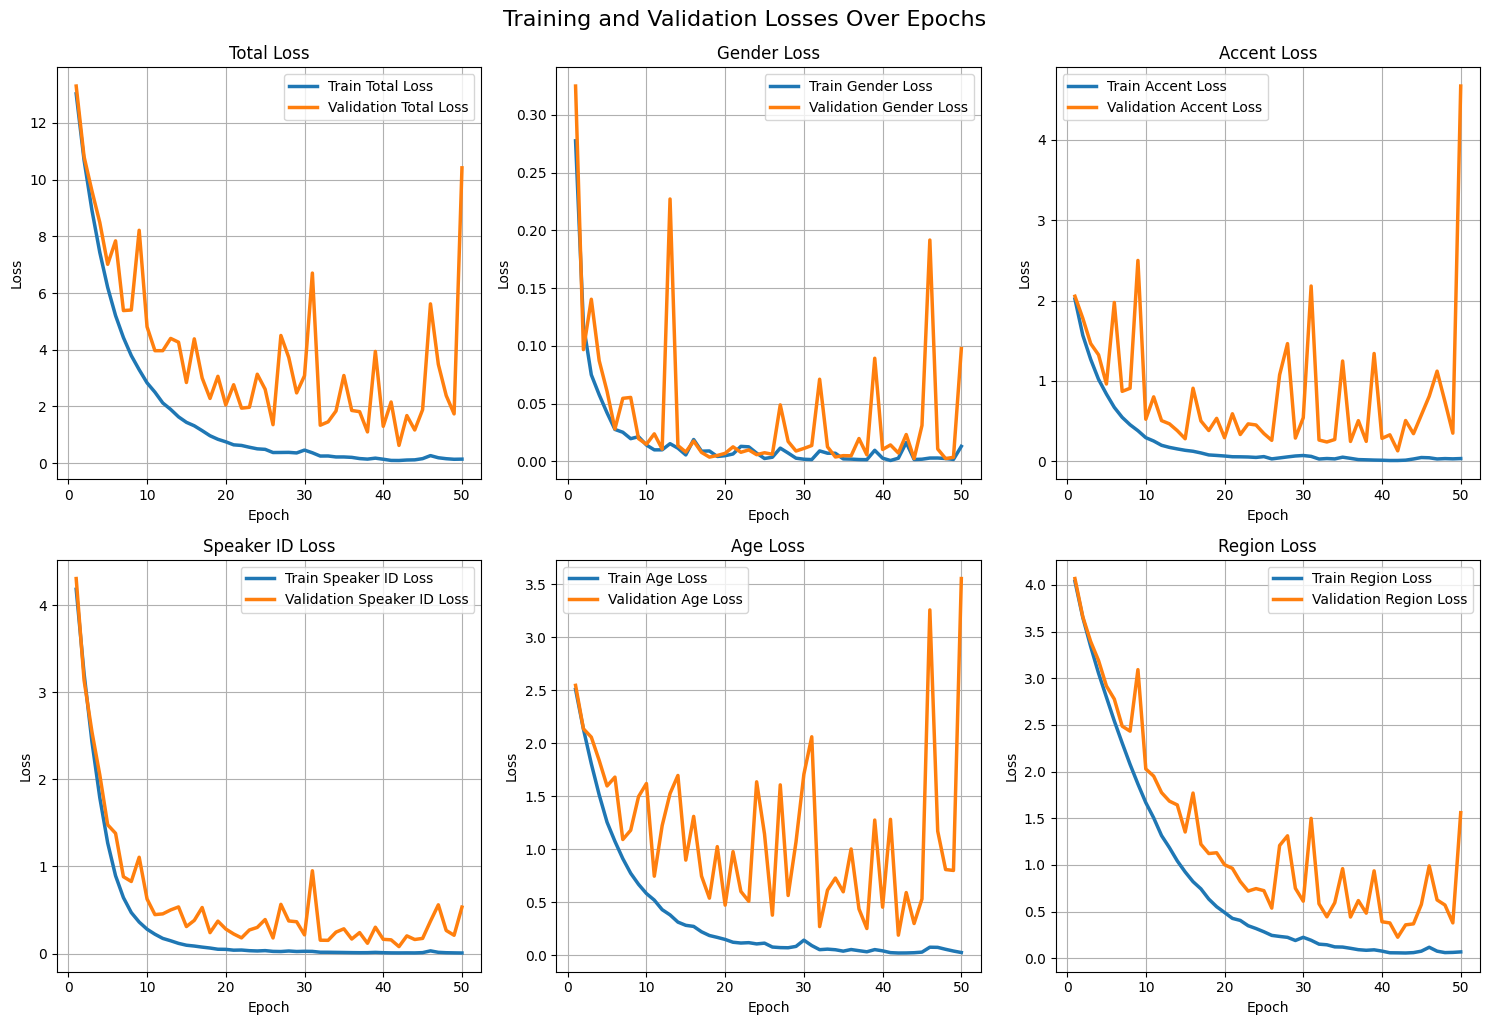

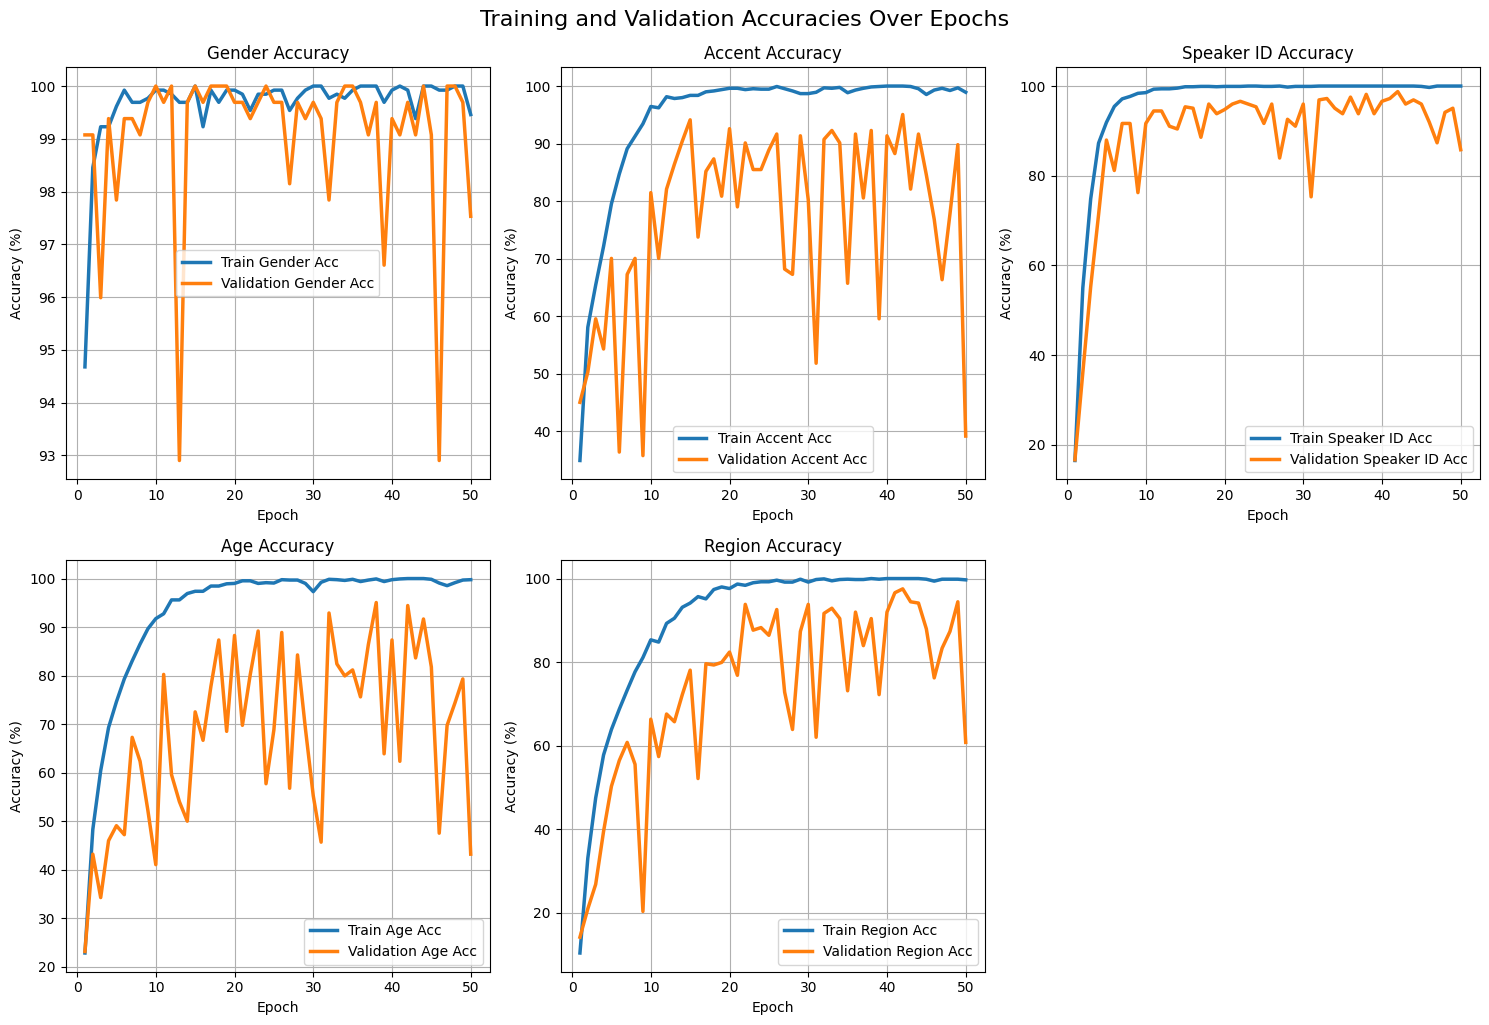

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plotting Training Metrics ---

# Ensure these lists are available from the training cell
# Example: train_losses = [...]
# Example: val_losses = [...]

epochs = range(1, len(train_losses) + 1)

# Set a common line width for all plots
LINE_WIDTH = 2.5 # You can adjust this value (e.g., 2, 3, etc.)

# Plotting Losses
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, label='Train Total Loss', linewidth=LINE_WIDTH)
plt.plot(epochs, val_losses, label='Validation Total Loss', linewidth=LINE_WIDTH)
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(epochs, train_gender_losses, label='Train Gender Loss', linewidth=LINE_WIDTH)
plt.plot(epochs, val_gender_losses, label='Validation Gender Loss', linewidth=LINE_WIDTH)
plt.title('Gender Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(epochs, train_accent_losses, label='Train Accent Loss', linewidth=LINE_WIDTH)
plt.plot(epochs, val_accent_losses, label='Validation Accent Loss', linewidth=LINE_WIDTH)
plt.title('Accent Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(epochs, train_speaker_id_losses, label='Train Speaker ID Loss', linewidth=LINE_WIDTH)
plt.plot(epochs, val_speaker_id_losses, label='Validation Speaker ID Loss', linewidth=LINE_WIDTH)
plt.title('Speaker ID Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(epochs, train_age_losses, label='Train Age Loss', linewidth=LINE_WIDTH)
plt.plot(epochs, val_age_losses, label='Validation Age Loss', linewidth=LINE_WIDTH)
plt.title('Age Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(epochs, train_region_losses, label='Train Region Loss', linewidth=LINE_WIDTH)
plt.plot(epochs, val_region_losses, label='Validation Region Loss', linewidth=LINE_WIDTH)
plt.title('Region Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.suptitle('Training and Validation Losses Over Epochs', y=1.02, fontsize=16)
plt.show()


# Plotting Accuracies
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs, [acc * 100 for acc in train_gender_accs], label='Train Gender Acc', linewidth=LINE_WIDTH)
plt.plot(epochs, [acc * 100 for acc in val_gender_accs], label='Validation Gender Acc', linewidth=LINE_WIDTH)
plt.title('Gender Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(epochs, [acc * 100 for acc in train_accent_accs], label='Train Accent Acc', linewidth=LINE_WIDTH)
plt.plot(epochs, [acc * 100 for acc in val_accent_accs], label='Validation Accent Acc', linewidth=LINE_WIDTH)
plt.title('Accent Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(epochs, [acc * 100 for acc in train_speaker_id_accs], label='Train Speaker ID Acc', linewidth=LINE_WIDTH)
plt.plot(epochs, [acc * 100 for acc in val_speaker_id_accs], label='Validation Speaker ID Acc', linewidth=LINE_WIDTH)
plt.title('Speaker ID Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(epochs, [acc * 100 for acc in train_age_accs], label='Train Age Acc', linewidth=LINE_WIDTH)
plt.plot(epochs, [acc * 100 for acc in val_age_accs], label='Validation Age Acc', linewidth=LINE_WIDTH)
plt.title('Age Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(epochs, [acc * 100 for acc in train_region_accs], label='Train Region Acc', linewidth=LINE_WIDTH)
plt.plot(epochs, [acc * 100 for acc in val_region_accs], label='Validation Region Acc', linewidth=LINE_WIDTH)
plt.title('Region Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.suptitle('Training and Validation Accuracies Over Epochs', y=1.02, fontsize=16)
plt.show()